# Default

In [ ]:
# Basic Data Manipulation and Analysis
import numpy as np
import pandas as pd
import json
import re
from collections import Counter

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and NLP
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, f_classif, chi2, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
import spacy
import textstat
import shap

# File and System Operations
import os
import glob
from google.colab import drive
import gc
import psutil
import joblib

# Misc
from wordcloud import WordCloud

# Installation commands (these should be run separately, not imported)
# !python -m spacy download en_core_web_sm
# !pip install textstat nltk pandas scikit-learn catboost shap

# NLTK downloads
nltk.download('vader_lexicon')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")


In [ ]:
drive.mount('/content/drive', force_remount=True)

base_dir = '/content/drive/My Drive/training_0726'

file_path = f'{base_dir}/MIRUKU.csv'

Mounted at /content/drive


In [ ]:
# try reading the CSV file using different encodings and print the first few lines
encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'utf-16']
for encoding in encodings:
    try:
        df_original = pd.read_csv(file_path, encoding=encoding)
        print(f'Successfully read the file with encoding: {encoding}')
        print(df_original.head())
        break
    except UnicodeDecodeError as e:
        print(f'Failed to read the file with encoding: {encoding}')
        print(f'Error: {e}')

df_original.head()

stratify_col = 'sensation'

print("\nOriginal class distribution:")
print(df_original[stratify_col].value_counts())

Successfully read the file with encoding: utf-8
                                            headline  clickbait  sensation  \
0                      £10bn bank bailout in Ireland          0          0   
1  Clearing the air: Positions of Canadian partie...          0          0   
2                   Football: Keïrman goes to Madrid          0          0   
3  Icelandic Landsbanki Íslands earnings on the i...          0          0   
4  Poll shows Prévval with clear lead, but inelig...          0          0   

   sensation_score                                   sensation_reason  \
0             1.10  The text is straightforward, factual, and lack...   
1             0.25  The title is factual and straightforward, lack...   
2             1.32  The text is straightforward and mildly interes...   
3             0.50  The text is factual and straightforward withou...   
4             1.35  The text is primarily informative, providing a...   

                 emotion arousal  arousal_sc

# EDA

## Basic Statistical

In [ ]:
print(df_original.shape)
print(df_original.columns)
print(df_original.dtypes)

(30424, 9)
Index(['headline', 'clickbait', 'sensation', 'sensation_score',
       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
       'arousal_reason'],
      dtype='object')
headline             object
clickbait             int64
sensation             int64
sensation_score     float64
sensation_reason     object
emotion              object
arousal              object
arousal_score       float64
arousal_reason       object
dtype: object


## Length of Headline

count    30424.000000
mean         9.087168
std          2.609171
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         26.000000
Name: headline, dtype: float64


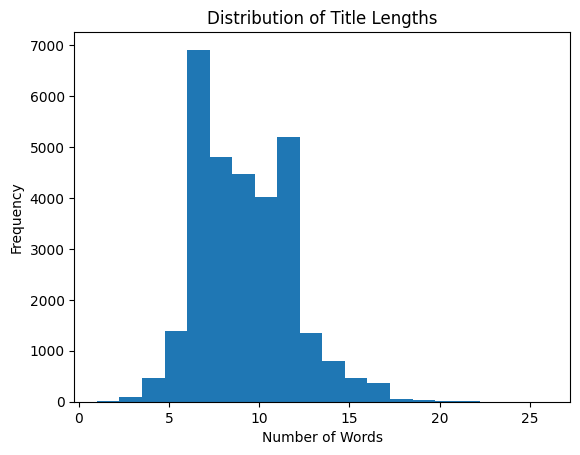

In [ ]:
# calculate title length and plot histogram
title_length = df_original['headline'].str.split().str.len()

print(title_length.describe())

plt.hist(title_length, bins=20)
plt.title('Distribution of Title Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Keyword extraction

### with stopword

Top keywords: ['15' '17' '18' '19' '2015' '21' '23' 'about' 'actually' 'after' 'all'
 'an' 'and' 'are' 'as' 'at' 'based' 'be' 'best' 'british' 'by' 'can' 'day'
 'dead' 'dies' 'do' 'ever' 'every' 'everyone' 'favorite' 'first' 'for'
 'from' 'get' 'has' 'have' 'her' 'here' 'his' 'how' 'if' 'in' 'into' 'is'
 'it' 'just' 'killed' 'kills' 'know' 'life' 'like' 'll' 'love' 'make'
 'man' 'more' 'most' 'need' 'new' 'no' 'not' 'obama' 'of' 'on' 'one' 'or'
 'out' 'over' 'people' 'president' 're' 'says' 'should' 'that' 'the'
 'their' 'these' 'things' 'this' 'time' 'times' 'to' 'two' 'uk' 'up' 'us'
 'was' 'we' 'what' 'when' 'which' 'who' 'will' 'with' 'women' 'world'
 'year' 'you' 'your' 'zodiac']


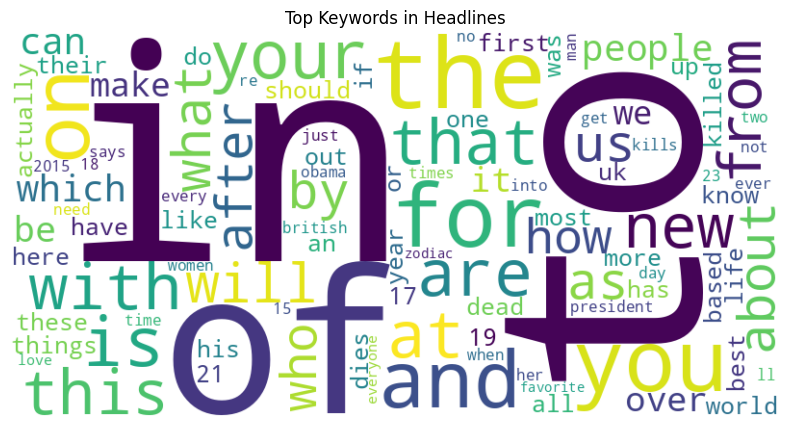

In [ ]:
# using TF-IDF to identify important keywords
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df_original['headline'])
feature_names = vectorizer.get_feature_names_out()
print("Top keywords:", feature_names)

# create a dictionary of words and their TF-IDF scores
tfidf_scores = dict(zip(feature_names, tfidf_matrix.sum(axis=0).tolist()[0]))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords in Headlines')
plt.show()

### w/o stopword

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Top keywords: ['10' '11' '12' '13' '15' '16' '17' '18' '19' '2015' '21' '22' '23' '24'
 '25' '27' 'actually' 'age' 'american' 'australian' 'based' 'best'
 'british' 'character' 'china' 'christmas' 'court' 'crash' 'day' 'dead'
 'dies' 'disney' 'favorite' 'food' 'found' 'game' 'government' 'guess'
 'halloween' 'harry' 'hilarious' 'home' 'house' 'india' 'iraq' 'killed'
 'kills' 'know' 'life' 'like' 'll' 'look' 'looks' 'love' 'man' 'movie'
 'need' 'new' 'north' 'obama' 'old' 'pakistan' 'party' 'people' 'photos'
 'pictures' 'police' 'president' 'questions' 'real' 'reasons' 'says' 'sex'
 'sign' 'south' 'star' 'tell' 'test' 'thing' 'things' 'time' 'times' 'try'
 'tv' 'tweets' 'uk' 'understand' 'video' 'want' 'watch' 'way' 'ways'
 'week' 'wins' 'woman' 'women' 'world' 'year' 'years' 'zodiac']


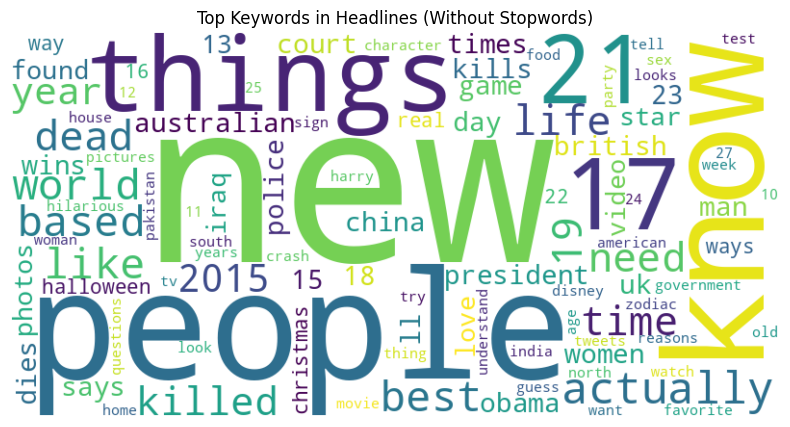

In [ ]:
# load spaCy English model
nlp = spacy.load("en_core_web_sm")

# function to get spaCy stopwords
def get_spacy_stop_words():
    return spacy.lang.en.stop_words.STOP_WORDS

# get spaCy stopwords
spacy_stop_words = get_spacy_stop_words()

# create a custom TF-IDF Vectorizer that removes stopwords
vectorizer = TfidfVectorizer(max_features=100, stop_words=list(spacy_stop_words))
tfidf_matrix = vectorizer.fit_transform(df_original['headline'])

# get the feature names (i.e., the top keywords)
feature_names = vectorizer.get_feature_names_out()
print("Top keywords:", feature_names)

# create a dictionary of words and their TF-IDF scores
tfidf_scores = dict(zip(feature_names, tfidf_matrix.sum(axis=0).tolist()[0]))

# create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)

# display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords in Headlines (Without Stopwords)')
plt.show()

# Features

## Number of Words in the Headline

In [ ]:
# dataframe number of words
df_now = df_original.copy()

# calculate words in headlines
df_now['Number of Words'] = df_now['headline'].apply(lambda x: len(str(x).split()))

print(df_now.head())

min_words = df_now['Number of Words'].min()
max_words = df_now['Number of Words'].max()
avg_words = df_now['Number of Words'].mean()

print(f"min number of words: {min_words}")
print(f"max number of words: {max_words}")
print(f"average words: {avg_words:.2f}")

# calculate the number of stop words for sensation and non-sensation categories, grouped by word count
sensation_counts = df_now[df_now['sensation'] == 1]['Number of Words'].value_counts().sort_index()
non_sensation_counts = df_now[df_now['sensation'] == 0]['Number of Words'].value_counts().sort_index()

# calculate the total number of stop words in each category
total_sensation = sensation_counts.sum()
total_non_sensation = non_sensation_counts.sum()

print("Sensation - Number of Words Counts:")
print(sensation_counts)
print(f"Total Sensation Count: {total_sensation}")

print("\nNon-Sensation - Number of Words Counts:")
print(non_sensation_counts)
print(f"Total Non-Sensation Count: {total_non_sensation}")

                                            headline  clickbait  sensation  \
0                      £10bn bank bailout in Ireland          0          0   
1  Clearing the air: Positions of Canadian partie...          0          0   
2                   Football: Keïrman goes to Madrid          0          0   
3  Icelandic Landsbanki Íslands earnings on the i...          0          0   
4  Poll shows Prévval with clear lead, but inelig...          0          0   

   sensation_score                                   sensation_reason  \
0             1.10  The text is straightforward, factual, and lack...   
1             0.25  The title is factual and straightforward, lack...   
2             1.32  The text is straightforward and mildly interes...   
3             0.50  The text is factual and straightforward withou...   
4             1.35  The text is primarily informative, providing a...   

                 emotion arousal  arousal_score  \
0  anger, fear, sadness      Yes         

In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_now.csv'
df_now.to_csv(output_path, index=False, encoding='utf-8')

## Number of stop words in the headlines

In [ ]:
# install and load spaCy’s English model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# function to count the number of stop words in each title
def count_stopwords(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.is_stop)

# copy df_now to df_nostop
df_nostop = df_now.copy()

# count the number of stop words in each title and add to a new DataFrame
df_nostop['Number of stop words'] = df_nostop['headline'].apply(count_stopwords)

# display new DataFrame
print(df_nostop.head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
                                            headline  clickbait  sensation  \
0                      £10bn bank bailout in Ireland          0          0   
1  Clearing the air: Positions of Canadian partie...          0          0   
2                   Football: Keïrman goes to Madrid          0          0   
3  Icelandic Landsbanki Íslands earnings on the i...          0          0   
4  Poll shows Prévval with clear lead, but inelig...          0          0   

   sensation_score                                   sensation_reason  \
0             1.10  The text is straight

In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_nostop.csv'
df_nostop.to_csv(output_path, index=False, encoding='utf-8')

## The ratio of the number of stop words to the number of content words

In [ ]:
# dataframe of ratio of the number of stop words to the number of content words
df_ratiostopwords = df_nostop.copy()

# function of calculating stopwrods and content words
def calculate_stopword_ratio(headline):
    doc = nlp(headline)
    stop_words = [token.text for token in doc if token.is_stop]
    content_words = [token.text for token in doc if not token.is_stop and token.is_alpha]  # consider only alphabetic content words
    if len(content_words) == 0:  # prevent division by zero error
        return 0
    return len(stop_words) / len(content_words)

# calculate the ratio of stop words to content words and store it in a new column
df_ratiostopwords['ratio_stopwords'] = df_ratiostopwords['headline'].apply(calculate_stopword_ratio)

print(df_ratiostopwords[['headline', 'ratio_stopwords']].head())

                                            headline  ratio_stopwords
0                      £10bn bank bailout in Ireland         0.333333
1  Clearing the air: Positions of Canadian partie...         0.333333
2                   Football: Keïrman goes to Madrid         0.250000
3  Icelandic Landsbanki Íslands earnings on the i...         0.400000
4  Poll shows Prévval with clear lead, but inelig...         0.500000


In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_ratiostopwords.csv'
df_ratiostopwords.to_csv(output_path, index=False, encoding='utf-8')

## Informality (Flesch-Kincaid Readability)

In [ ]:
# copy df_fkreadability from df_ratiostopwords
df_fkreadability = df_ratiostopwords.copy()

# function to calculate the Flesch-Kincaid readability score
def calculate_fk_readability(headline):
    return textstat.flesch_kincaid_grade(headline)

# calculate the readability score for each heading and store it in a new column
df_fkreadability['fk_readability'] = df_fkreadability['headline'].apply(calculate_fk_readability)

print(df_fkreadability[['headline', 'fk_readability']].head())

                                            headline  fk_readability
0                      £10bn bank bailout in Ireland             0.5
1  Clearing the air: Positions of Canadian partie...            10.7
2                   Football: Keïrman goes to Madrid             2.9
3  Icelandic Landsbanki Íslands earnings on the i...             9.6
4  Poll shows Prévval with clear lead, but inelig...            10.3


In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_fkreadability.csv'
df_fkreadability.to_csv(output_path, index=False, encoding='utf-8')

## Sentence Subjectivity and Objectivity Evaluation

In [ ]:
# initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# function to calculate subjectivity and objectivity scores
def get_subjectivity_objectivity(text):
    sentiment_scores = sid.polarity_scores(text)
    subjectivity = sentiment_scores['pos'] + sentiment_scores['neg']
    objectivity = sentiment_scores['neu']
    return subjectivity, objectivity

# calculate subjectivity and objectivity scores
df_subobjectivity = df_fkreadability.copy()
df_subobjectivity['subjectivity'], df_subobjectivity['objectivity'] = zip(*df_fkreadability['headline'].apply(get_subjectivity_objectivity))

print(df_subobjectivity[['headline', 'subjectivity', 'objectivity']])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                headline  subjectivity  \
0                          £10bn bank bailout in Ireland         0.259   
1      Clearing the air: Positions of Canadian partie...         0.231   
2                       Football: Keïrman goes to Madrid         0.000   
3      Icelandic Landsbanki Íslands earnings on the i...         0.277   
4      Poll shows Prévval with clear lead, but inelig...         0.213   
...                                                  ...           ...   
30419  Zimmerman stands before judge for the Trayvon ...         0.000   
30420  Zoo Animals Around The World Are Opening Their...         0.000   
30421  Zoo elephants live shorter lives than their wi...         0.123   
30422  Zoombak Tracks Your Dog, Your Car, Even Your C...         0.000   
30423                Zuma Faces New Charges After Ruling         0.296   

       objectivity  
0            0.741  
1            0.769  
2            1.000  
3            0.723  
4     

In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_subobjectivity.csv'
df_subobjectivity.to_csv(output_path, index=False, encoding='utf-8')

## Sentiment Analysis

In [ ]:
# initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# function to calculate subjectivity and objectivity scores
def get_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['pos'], sentiment_scores['compound']

# calculate subjectivity and objectivity scores
df_sentiment = df_subobjectivity.copy()
df_sentiment[['neg', 'neu', 'pos', 'compound']] = df_subobjectivity['headline'].apply(lambda x: pd.Series(get_sentiment(x)))

print(df_sentiment[['headline', 'neg', 'neu', 'pos', 'compound']])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                headline    neg    neu    pos  \
0                          £10bn bank bailout in Ireland  0.259  0.741  0.000   
1      Clearing the air: Positions of Canadian partie...  0.000  0.769  0.231   
2                       Football: Keïrman goes to Madrid  0.000  1.000  0.000   
3      Icelandic Landsbanki Íslands earnings on the i...  0.000  0.723  0.277   
4      Poll shows Prévval with clear lead, but inelig...  0.000  0.787  0.213   
...                                                  ...    ...    ...    ...   
30419  Zimmerman stands before judge for the Trayvon ...  0.000  1.000  0.000   
30420  Zoo Animals Around The World Are Opening Their...  0.000  1.000  0.000   
30421  Zoo elephants live shorter lives than their wi...  0.123  0.877  0.000   
30422  Zoombak Tracks Your Dog, Your Car, Even Your C...  0.000  1.000  0.000   
30423                Zuma Faces New Charges After Ruling  0.296  0.704  0.000   

       compound  
0       -

In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_sentiment.csv'
df_sentiment.to_csv(output_path, index=False, encoding='utf-8')

## Elongated Words

In [ ]:
# copy df_exclamark to create a new data frame
df_elongated = df_sentiment.copy()

# define a function to count the number of extended words in each title
def count_elongated_words(text):
    elongated_pattern = re.compile(r'\b\w*(\w)\1{2,}\w*\b')
    elongated_words = elongated_pattern.findall(text)
    return len(elongated_words)

# count the number of extended words in each title
df_elongated['elongated_word_count'] = df_elongated['headline'].apply(count_elongated_words)

print(df_elongated.head())

                                            headline  clickbait  sensation  \
0                      £10bn bank bailout in Ireland          0          0   
1  Clearing the air: Positions of Canadian partie...          0          0   
2                   Football: Keïrman goes to Madrid          0          0   
3  Icelandic Landsbanki Íslands earnings on the i...          0          0   
4  Poll shows Prévval with clear lead, but inelig...          0          0   

   sensation_score                                   sensation_reason  \
0             1.10  The text is straightforward, factual, and lack...   
1             0.25  The title is factual and straightforward, lack...   
2             1.32  The text is straightforward and mildly interes...   
3             0.50  The text is factual and straightforward withou...   
4             1.35  The text is primarily informative, providing a...   

                 emotion arousal  arousal_score  \
0  anger, fear, sadness      Yes         

In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_elongated.csv'
df_elongated.to_csv(output_path, index=False, encoding='utf-8')

## Punctuation

In [ ]:
# copy df_elongated to create a Punctuation data frame
df_punctuation = df_elongated.copy()

# function to count the number of specific punctuation marks in each title
def count_punctuation(text):
    contracted_word_forms_count = len(re.findall(r"\b\w+['’]\w+\b", text))  # count abbreviations
    single_quotes_count = text.count("'") - contracted_word_forms_count  # remove single quotes from abbreviations
    punctuation_counts = {
        'exclamation_count': text.count('!'),
        'currency_count': len(re.findall(r'[$€£]', text)),
        'informal_marks_count': len(re.findall(r'!|\?|…|\.\.\.|:\*\*\*|!!!', text)),
        'single_quotes_count': single_quotes_count,
        'double_quotes_count': text.count('"'),
        'contracted_word_forms_count': contracted_word_forms_count
    }
    return pd.Series(punctuation_counts)

# count the number of specific punctuation marks in each title
df_punctuation[['exclamation_count', 'currency_count', 'informal_marks_count', 'single_quotes_count', 'double_quotes_count', 'contracted_word_forms_count']] = df_punctuation['headline'].apply(count_punctuation)

print(df_punctuation.head())

# count the total number of each type of punctuation mark
total_exclamation = df_punctuation['exclamation_count'].sum()
total_currency = df_punctuation['currency_count'].sum()
total_informal_marks = df_punctuation['informal_marks_count'].sum()
total_single_quotes = df_punctuation['single_quotes_count'].sum()
total_double_quotes = df_punctuation['double_quotes_count'].sum()
total_quotes = total_single_quotes + total_double_quotes
total_contracted_word_forms = df_punctuation['contracted_word_forms_count'].sum()

# print the total number of each type of punctuation mark
print(f"Total number of exclamation marks: {total_exclamation}")
print(f"Total number of currency signs: {total_currency}")
print(f"Total number of informal marks: {total_informal_marks}")
print(f"Total number of single quotes: {total_single_quotes}")
print(f"Total number of double quotes: {total_double_quotes}")
print(f"Total number of quotes: {total_quotes}")
print(f"Total number of contracted word forms: {total_contracted_word_forms}")


                                            headline  clickbait  sensation  \
0                      £10bn bank bailout in Ireland          0          0   
1  Clearing the air: Positions of Canadian partie...          0          0   
2                   Football: Keïrman goes to Madrid          0          0   
3  Icelandic Landsbanki Íslands earnings on the i...          0          0   
4  Poll shows Prévval with clear lead, but inelig...          0          0   

   sensation_score                                   sensation_reason  \
0             1.10  The text is straightforward, factual, and lack...   
1             0.25  The title is factual and straightforward, lack...   
2             1.32  The text is straightforward and mildly interes...   
3             0.50  The text is factual and straightforward withou...   
4             1.35  The text is primarily informative, providing a...   

                 emotion arousal  arousal_score  \
0  anger, fear, sadness      Yes         

In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_punctuation.csv'
df_punctuation.to_csv(output_path, index=False, encoding='utf-8')

## TF-IDF

In [ ]:
# copy a new df_tfidf from df_ngrams_syntactic
df_tfidf = df_punctuation.copy()

# use TfidfVectorizer to calculate TF-IDF features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_tfidf['headline'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{feature}' for feature in tfidf_feature_names])

# add TF-IDF features back to df_tfidf
df_tfidf = pd.concat([df_tfidf, tfidf_df], axis=1)

print(df_tfidf.head())

                                            headline  clickbait  sensation  \
0                      £10bn bank bailout in Ireland          0          0   
1  Clearing the air: Positions of Canadian partie...          0          0   
2                   Football: Keïrman goes to Madrid          0          0   
3  Icelandic Landsbanki Íslands earnings on the i...          0          0   
4  Poll shows Prévval with clear lead, but inelig...          0          0   

   sensation_score                                   sensation_reason  \
0             1.10  The text is straightforward, factual, and lack...   
1             0.25  The title is factual and straightforward, lack...   
2             1.32  The text is straightforward and mildly interes...   
3             0.50  The text is factual and straightforward withou...   
4             1.35  The text is primarily informative, providing a...   

                 emotion arousal  arousal_score  \
0  anger, fear, sadness      Yes         

In [ ]:
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_tfidf.csv'
df_tfidf.to_csv(output_path, index=False, encoding='utf-8')

## Syntactic Ngrams

In [ ]:
# load df-tfidf CSV
input_path = f'{base_dir}/df_tfidf.csv'
df_tfidf = pd.read_csv(input_path, encoding='utf-8')

# load spaCy's language model
nlp = spacy.load("en_core_web_sm")

# copy of df_4grams_syntactic from df_tfidf
df_4grams_syntactic = df_tfidf.copy()

# extract dependency tags
def extract_dep_tags(doc):
    return [token.dep_ for token in doc]

# apply a function to a DataFrame and calculate statistics
df_4grams_syntactic['dep_tags'] = df_4grams_syntactic['headline'].apply(lambda x: extract_dep_tags(nlp(x)))

# compute statistics on the number of syntactic dependencies
dep_counts = df_4grams_syntactic['dep_tags'].apply(len)

min_deps = dep_counts.min()
max_deps = dep_counts.max()
avg_deps = dep_counts.mean()

print("\ndependency stats:")
print(f"min dependencies: {min_deps}")
print(f"max dependencies: {max_deps}")
print(f"average dependencies: {avg_deps:.2f}")

# calculate syntactic tree depth
def tree_depth(doc):
    def token_depth(token):
        depth = 0
        while token.head != token:
            token = token.head
            depth += 1
        return depth

    return max(token_depth(token) for token in doc)

# apply function to data frame
df_4grams_syntactic['tree_depth'] = df_4grams_syntactic['headline'].apply(lambda x: tree_depth(nlp(x)))

min_depth = df_4grams_syntactic['tree_depth'].min()
max_depth = df_4grams_syntactic['tree_depth'].max()
avg_depth = df_4grams_syntactic['tree_depth'].mean()

print("\ntree depth stats:")
print(f"min tree depth: {min_depth}")
print(f"max tree depth: {max_depth}")
print(f"average tree depth: {avg_depth:.2f}")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



dependency stats:
min dependencies: 1
max dependencies: 27
average dependencies: 9.80

tree depth stats:
min tree depth: 0
max tree depth: 11
average tree depth: 3.53
CPU times: user 9min 45s, sys: 13.3 s, total: 9min 58s
Wall time: 9min 59s


In [ ]:
# save results to new CSV file
output_path = f'{base_dir}/df_depth_syntactic.csv'
df_4grams_syntactic.to_csv(output_path, index=False, encoding='utf-8')

print(f"\nsaving to: {output_path}")

In [ ]:
%%time

n = int(4)

# generate dependency n-grams and count them
def generate_syntactic_ngrams(dep_tags, n):
    dep_ngrams = list(ngrams(dep_tags, n))
    return Counter(dep_ngrams)

# generate n-gram features for each headline
def add_syntactic_ngram_features(df, n):
    df[f'syntactic_{n}grams'] = df['dep_tags'].apply(lambda tags: generate_syntactic_ngrams(tags, n))
    return df

# expand n-gram features into separate columns
def expand_ngrams(df, n, prefix='syntactic'):
    ngram_col = f'{prefix}_{n}grams'
    all_ngrams = set(ngram for ngram_counter in df[ngram_col] for ngram in ngram_counter)
    new_columns = {f'{ngram_col}_{"_".join(ngram)}': df[ngram_col].apply(lambda x: x[ngram] if ngram in x else 0)
                   for ngram in all_ngrams}
    df = df.drop(columns=[ngram_col])
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
    return df

# generate and expand syntactic n-gram features
df_4grams_syntactic = add_syntactic_ngram_features(df_4grams_syntactic, n)
df_4grams_syntactic = expand_ngrams(df_4grams_syntactic, n)

# print the generated results
print(df_4grams_syntactic.head())

                                            headline  clickbait  sensation  \
0                      £10bn bank bailout in Ireland          0          0   
1  Clearing the air: Positions of Canadian partie...          0          0   
2                   Football: Keïrman goes to Madrid          0          0   
3  Icelandic Landsbanki Íslands earnings on the i...          0          0   
4  Poll shows Prévval with clear lead, but inelig...          0          0   

   sensation_score                                   sensation_reason  \
0             1.10  The text is straightforward, factual, and lack...   
1             0.25  The title is factual and straightforward, lack...   
2             1.32  The text is straightforward and mildly interes...   
3             0.50  The text is factual and straightforward withou...   
4             1.35  The text is primarily informative, providing a...   

                 emotion arousal  arousal_score  \
0  anger, fear, sadness      Yes         

In [ ]:
%%time

# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_4grams_syntactic.csv'
df_4grams_syntactic.to_csv(output_path, index=False, encoding='utf-8')

CPU times: user 47min 29s, sys: 5.43 s, total: 47min 35s
Wall time: 47min 46s


# Feature Selection

In [ ]:
%%time

# specify the home folder path
base_dir = '/content/drive/My Drive/training_0726'

# load the saved CSV file
df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv', encoding='utf-8')

# set features and target variables
X = df_4grams_syntactic
y = df_4grams_syntactic['sensation']

# define columns to exclude
exclude_columns = ['headline', 'clickbait', 'sensation_score',
                   'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                   'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                   'ner_features', 'pos_freq', 'dep_tags', 'sensation']

# remove non-numeric columns and columns that need to be excluded
numeric_columns = X.select_dtypes(include=[np.number]).columns
valid_columns = [col for col in numeric_columns if col not in exclude_columns]
X_numeric = X[valid_columns]

print(f"Original number of features: {X.shape[1]}")
print(f"Number of numeric features: {len(numeric_columns)}")
print(f"The final number of features selected: {X_numeric.shape[1]}")
print("Partially selected features:")
print(list(X_numeric.columns)[:20])  # the first 20 feature names

Original number of features: 52200
Number of numeric features: 52194
The final number of features selected: 52190
Partially selected features:
['Number of words in the headline', 'Number of stop words', 'ratio_stopwords', 'fk_readability', 'subjectivity', 'objectivity', 'neg', 'neu', 'pos', 'compound', 'elongated_word_count', 'exclamation_count', 'currency_count', 'informal_marks_count', 'single_quotes_count', 'double_quotes_count', 'contracted_word_forms_count', 'tfidf_00', 'tfidf_000', 'tfidf_000th']
CPU times: user 13min 24s, sys: 53.3 s, total: 14min 17s
Wall time: 14min 13s


In [ ]:
thresholds = [0.0001, 0.001, 0.01, 0.1]
for threshold in thresholds:
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X_numeric)
    print(f"Threshold: {threshold}, Features retained: {X_selected.shape[1]}")

Threshold: 0.0001, Features retained: 9437
Threshold: 0.001, Features retained: 1236
Threshold: 0.01, Features retained: 73
Threshold: 0.1, Features retained: 8


In [ ]:
%%time
# save the excluded features
output_file = f'{base_dir}/selected_features.csv'
X_numeric.to_csv(output_file, index=False)
print(f"features saved to: {output_file}")

features saved to: /content/drive/My Drive/training_0726/selected_features.csv
CPU times: user 49min 51s, sys: 7.25 s, total: 49min 59s
Wall time: 50min 53s


In [ ]:
# # perform garbage collection
# gc.collect()

# # delete large objects that are no longer needed
# del df_4grams_syntactic
# del X
# del X_numeric
# gc.collect()

# print("GC completed")

GC completed


## Filter

In [ ]:
%%time

# specify the home folder path
base_dir = '/content/drive/My Drive/training_0726'

def print_memory_usage():
    print(f"RAM usage: {psutil.virtual_memory().percent}%")

print_memory_usage()

# load the saved CSV file
X_numeric = pd.read_csv(f'{base_dir}/selected_features.csv', encoding='utf-8')

# read only the target variable
y = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv', usecols=['sensation'])['sensation']

print_memory_usage()

RAM usage: 64.3%
RAM usage: 62.2%
CPU times: user 14min 45s, sys: 40.5 s, total: 15min 25s
Wall time: 15min 24s


In [ ]:
%%time
def variance_threshold_selection(X, threshold=0.001):
    print("beging variance threshold filtering")
    var_selector = VarianceThreshold(threshold=threshold)
    var_selector.fit(X)
    var_mask = var_selector.get_support()
    var_features = X.columns[var_mask].tolist()

    print(f"Variance threshold screening is completed, the number of selected features：{len(var_features)}")
    print_memory_usage()

    return var_features

var_features = variance_threshold_selection(X_numeric)

# save features
output_file = f'{base_dir}/var_features.csv'
X_numeric[var_features].to_csv(output_file, index=False)

# save feature name
with open(f'{base_dir}/var_features.txt', 'w') as f:
    f.write('\n'.join(var_features))

print("variance threshold feature saved")
print_memory_usage()

del var_features
gc.collect()

beging variance threshold filtering
Variance threshold screening is completed, the number of selected features：1236
RAM usage: 68.3%
variance threshold feature saved
RAM usage: 54.2%
CPU times: user 21.1 s, sys: 11.2 s, total: 32.3 s
Wall time: 36.2 s


0

## Cuckoo Search via Lévy flights

In [ ]:
%%time

def print_memory_usage():
    print(f"RAM usage: {psutil.virtual_memory().percent}%")

# specify the home folder path
base_dir = '/content/drive/My Drive/training_0726'

# read variance threshold feature
with open(f'{base_dir}/var_features.txt', 'r') as f:
    var_features = [line.strip() for line in f]

# read selected_features.csv file
df_cuckoo = pd.read_csv(f'{base_dir}/var_features.csv', encoding='utf-8')

# select variance threshold features
df_cuckoo = df_cuckoo[var_features]

# check the original data frame
print("Original data frame information:")
print(f"Shape: {df_cuckoo.shape}")
print(f"Column name: {df_cuckoo.columns.tolist()}")
print("\nFirst few lines of data:")
print(df_cuckoo.head())
print("\nData type: ")
print(df_cuckoo.dtypes)
print("\nNon-null value statistics:")
print(df_cuckoo.notnull().sum())

print_memory_usage()

# use df_cuckoo as feature set
X = df_cuckoo
y = pd.read_csv(f'{base_dir}/MIRUKU.csv', usecols=['sensation'])['sensation']

print("Characteristic columns:", X.columns.tolist())
print("Target variable:", y.name)
print("Shape of X: ", X.shape)
print("Shape of y:", y.shape)

print(f"Number of processed features: {X.shape[1]}")

print_memory_usage()

# # clear variables
# del var_features
# gc.collect()
# print_memory_usage()
# del df_cuckoo
# gc.collect()
# print_memory_usage()

Original data frame information:
Shape: (30424, 1236)
Column name: ['Number of words in the headline', 'Number of stop words', 'ratio_stopwords', 'fk_readability', 'subjectivity', 'objectivity', 'neg', 'neu', 'pos', 'compound', 'elongated_word_count', 'exclamation_count', 'currency_count', 'informal_marks_count', 'single_quotes_count', 'double_quotes_count', 'contracted_word_forms_count', 'tfidf_17', 'tfidf_19', 'tfidf_2015', 'tfidf_21', 'tfidf_about', 'tfidf_actually', 'tfidf_after', 'tfidf_all', 'tfidf_and', 'tfidf_are', 'tfidf_as', 'tfidf_at', 'tfidf_based', 'tfidf_be', 'tfidf_best', 'tfidf_by', 'tfidf_can', 'tfidf_do', 'tfidf_first', 'tfidf_for', 'tfidf_from', 'tfidf_have', 'tfidf_here', 'tfidf_how', 'tfidf_in', 'tfidf_is', 'tfidf_it', 'tfidf_know', 'tfidf_life', 'tfidf_like', 'tfidf_make', 'tfidf_more', 'tfidf_most', 'tfidf_need', 'tfidf_new', 'tfidf_of', 'tfidf_on', 'tfidf_one', 'tfidf_or', 'tfidf_over', 'tfidf_people', 'tfidf_should', 'tfidf_that', 'tfidf_the', 'tfidf_their', 't

In [ ]:
%%time
# Cuckoo Search
def levy_flight(beta=1.5):
    sigma = (math.gamma(1+beta) * math.sin(math.pi*beta/2) / (math.gamma((1+beta)/2) * beta * 2**((beta-1)/2)))**(1/beta)
    u = np.random.randn(1) * sigma
    v = np.random.randn(1)
    step = u / abs(v)**(1/beta)
    return step

def score_function(X, y):
    if X.shape[1] == 0:
        return 0
    clf = DecisionTreeClassifier(random_state=42)
    scores = cross_val_score(clf, X, y, cv=5)
    return np.mean(scores)

def cuckoo_search(X, y, n_nests=25, pa=0.25, n_iterations=100):
    n_features = X.shape[1]
    nests = np.random.randint(2, size=(n_nests, n_features))

    fitness = np.array([score_function(X.iloc[:, nest == 1], y) for nest in nests])
    best_nest = nests[np.argmax(fitness)]
    best_fitness = np.max(fitness)

    for _ in range(n_iterations):
        cuckoo = nests[np.random.randint(n_nests)].copy()
        cuckoo = np.random.randint(2, size=n_features)

        step_size = levy_flight()
        cuckoo = np.where(np.random.rand(n_features) < step_size, 1-cuckoo, cuckoo)

        j = np.random.randint(n_nests)
        if score_function(X.iloc[:, cuckoo == 1], y) > fitness[j]:
            nests[j] = cuckoo
            fitness[j] = score_function(X.iloc[:, cuckoo == 1], y)

        worst = np.argsort(fitness)[:int(n_nests*pa)]
        nests[worst] = np.random.randint(2, size=(len(worst), n_features))
        fitness[worst] = np.array([score_function(X.iloc[:, nest == 1], y) for nest in nests[worst]])

        if np.max(fitness) > best_fitness:
            best_fitness = np.max(fitness)
            best_nest = nests[np.argmax(fitness)]

    return best_nest, best_fitness

print("Running Cuckoo Search...")
best_features, best_fitness = cuckoo_search(X, y)
selected_features = X.columns[best_features == 1]
X_selected = X[selected_features]

print(f"The number of features selected by Cuckoo Search: {len(selected_features)}")
print(f"Best score obtained by Cuckoo Search: {best_fitness:.4f}")

print_memory_usage()

# # clear variables
# del best_features, best_fitness
# gc.collect()
# print_memory_usage()

Running Cuckoo Search...
The number of features selected by Cuckoo Search: 616
Best score obtained by Cuckoo Search: 0.6015
RAM usage: 54.1%
CPU times: user 2h 25min 40s, sys: 4.53 s, total: 2h 25min 45s
Wall time: 2h 25min 8s



Selected features:
Number of words in the headline
Number of stop words
subjectivity
pos
compound
elongated_word_count
double_quotes_count
contracted_word_forms_count
tfidf_19
tfidf_2015
tfidf_21
tfidf_actually
tfidf_all
tfidf_and
tfidf_are
tfidf_at
tfidf_based
tfidf_best
tfidf_by
tfidf_do
tfidf_first
tfidf_for
tfidf_from
tfidf_is
tfidf_life
tfidf_like
tfidf_need
tfidf_new
tfidf_of
tfidf_one
tfidf_or
tfidf_should
tfidf_that
tfidf_the
tfidf_their
tfidf_things
tfidf_this
tfidf_to
tfidf_us
tfidf_we
tfidf_with
tfidf_you
syntactic_4grams_amod_compound_punct_compound
syntactic_4grams_ROOT_dobj_prep_pcomp
syntactic_4grams_nmod_punct_nsubj_aux
syntactic_4grams_nummod_amod_ROOT_prep
syntactic_4grams_nsubj_ROOT_compound_poss
syntactic_4grams_nummod_compound_punct_compound
syntactic_4grams_compound_pobj_punct_prep
syntactic_4grams_compound_nsubj_ROOT_attr
syntactic_4grams_acomp_prep_pobj_prep
syntactic_4grams_npadvmod_aux_nsubj_ROOT
syntactic_4grams_compound_compound_ROOT_poss
syntactic_4grams_n

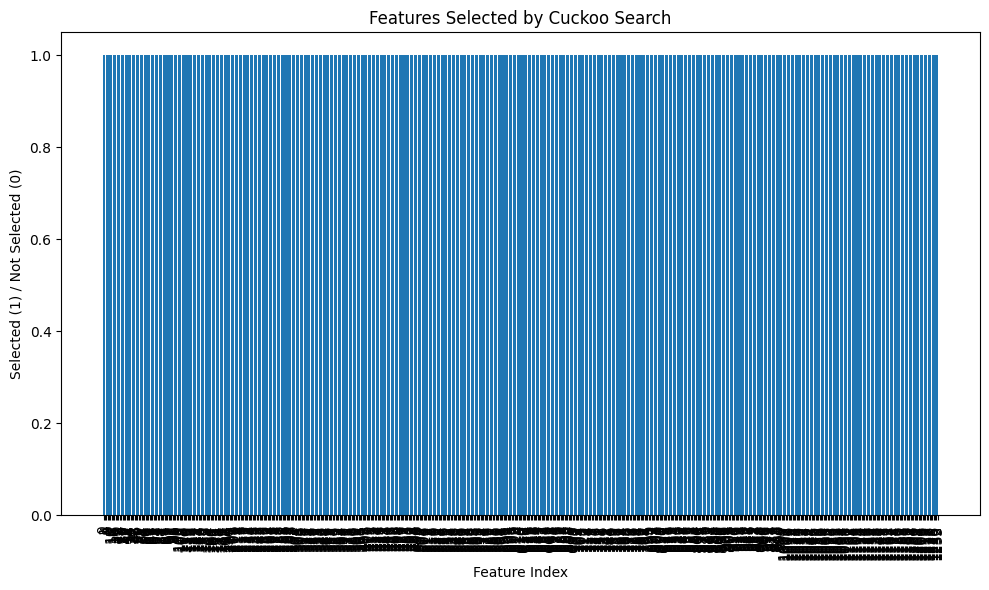


Statistics of selected features:
       Number of words in the headline  Number of stop words  subjectivity  \
count                     30424.000000          30424.000000  30424.000000   
mean                          9.087168              3.342296      0.209339   
std                           2.609171              2.209884      0.196181   
min                           1.000000              0.000000      0.000000   
25%                           7.000000              2.000000      0.000000   
50%                           9.000000              3.000000      0.220000   
75%                          11.000000              5.000000      0.355000   
max                          26.000000             14.000000      1.000000   

                pos      compound  elongated_word_count  double_quotes_count  \
count  30424.000000  30424.000000          30424.000000         30424.000000   
mean       0.100209     -0.004028              0.006278             0.155436   
std        0.151700    

In [ ]:
%%time
# print selected features
print("\nSelected features:")
for feature in selected_features:
    print(feature)

# create a DataFrame to display the selected features and their index in the original feature set
df_selected_features = pd.DataFrame({
    'Feature': selected_features,
    'Index': [list(X.columns).index(feature) for feature in selected_features]
})
df_selected_features = df_selected_features.sort_values('Index')

print("\nSelected features with their indices in the original feature set:")
print(df_selected_features.to_string(index=False))

# visualize selected features
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features)), [1]*len(selected_features))
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.title('Features Selected by Cuckoo Search')
plt.xticks(range(len(selected_features)), df_selected_features['Index'], rotation=90)
plt.tight_layout()
plt.show()

# print statistics for selected features
print("\nStatistics of selected features:")
print(X_selected.describe())

print_memory_usage()

# # clear variables
# plt.close()
# del selected_features, X_selected
# gc.collect()
# print_memory_usage()

In [ ]:
%%time
# save the merged data frame as a CSV file and specify the encoding as utf-8
output_path = f'{base_dir}/df_selected_features.csv'
df_selected_features.to_csv(output_path, index=False, encoding='utf-8')

print_memory_usage()

# # clear variables
# del X, y, X_selected, df_selected_features
# gc.collect()
# print_memory_usage()

RAM usage: 54.1%
CPU times: user 10.6 ms, sys: 1.01 ms, total: 11.6 ms
Wall time: 1.79 s


# Threshold

## XGBoost: Calculate threshold by using arousal score and by using PCA on emotions

Optimal Threshold: 0.4457232654094696

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3243
           1       0.98      0.97      0.97      2842

    accuracy                           0.98      6085
   macro avg       0.98      0.98      0.98      6085
weighted avg       0.98      0.98      0.98      6085



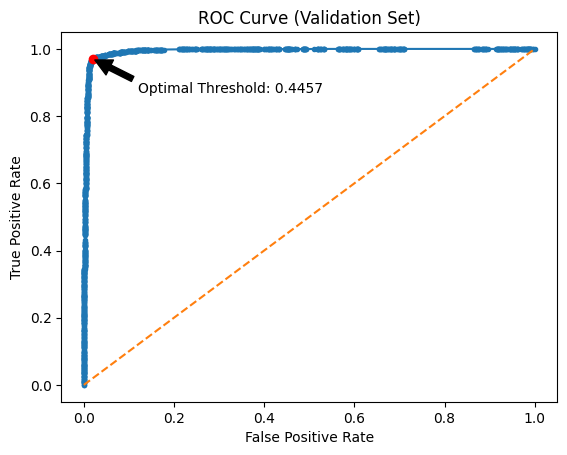


Test Set AUC: 0.9952525365628084

Test Set Results (First 10 rows):
       sensation_score  arousal_score  emotion_pca  true_sensation  \
27421           0.3750          0.353     0.000000               0   
3858            0.3750          0.580     0.675084               0   
29191           0.1250          0.350     0.000000               0   
15484           0.9375          0.680     0.426882               1   
2325            0.7500          0.250     0.000000               0   
4519            0.8750          0.250     0.416768               1   
25322           1.0000          0.455     0.349376               1   
3498            1.0000          0.710     0.733004               1   
22478           0.1875          0.353     0.000000               0   
9644            1.0000          0.921     0.389850               1   

       combined_score  predicted_sensation  
27421        0.005542                    0  
3858         0.000403                    0  
29191        0.000050    

In [ ]:
df_threshold = df_original.copy()

# data preprocessing
df_threshold['arousal'] = df_threshold['arousal'].map({'Yes': 1, 'No': 0})

emotions = ['joy', 'surprise', 'anticipation', 'trust', 'anger', 'fear', 'sadness', 'disgust', 'neutral']
for emotion in emotions:
    df_threshold[emotion] = df_threshold['emotion'].apply(lambda x: 1 if emotion in x else 0)

emotion_data = df_threshold[emotions]

pca = PCA(n_components=1)
principal_component = pca.fit_transform(emotion_data)
df_threshold['emotion_pca'] = principal_component

scaler = MinMaxScaler()
df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']] = scaler.fit_transform(df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']])

# features and target variables
X = df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']]
y = df_threshold['sensation']

# split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# XGBoost
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# best threshold on validation set
val_predictions = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, val_predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# final evaluation on test set
test_predictions = model.predict_proba(X_test)[:, 1]
test_predictions_binary = (test_predictions >= optimal_threshold).astype(int)

print("\nTest Set Evaluation:")
print(classification_report(y_test, test_predictions_binary))

# ROC curve with best threshold
plt.figure()
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')

optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]
plt.plot(optimal_fpr, optimal_tpr, 'ro')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.4f}',
             xy=(optimal_fpr, optimal_tpr),
             xytext=(optimal_fpr + 0.1, optimal_tpr - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# AUC of test set
test_auc = roc_auc_score(y_test, test_predictions)
print(f"\nTest Set AUC: {test_auc}")

# apply combined scores on the test set
df_test = pd.DataFrame(X_test, columns=['sensation_score', 'arousal_score', 'emotion_pca'])
df_test['true_sensation'] = y_test
df_test['combined_score'] = test_predictions
df_test['predicted_sensation'] = test_predictions_binary

print("\nTest Set Results (First 10 rows):")
print(df_test.head(10))

# save best XGBoost threshold and model
joblib.dump(optimal_threshold, f'{base_dir}/XGoptimal_threshold.joblib')
model.save_model(f'{base_dir}/xgboost_threshold_model.json')

## ADABoost: Calculate threshold by using arousal score and by using PCA on emotions

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Optimal Threshold: 0.5065828543375743

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3243
           1       0.98      0.97      0.97      2842

    accuracy                           0.98      6085
   macro avg       0.98      0.98      0.98      6085
weighted avg       0.98      0.98      0.98      6085



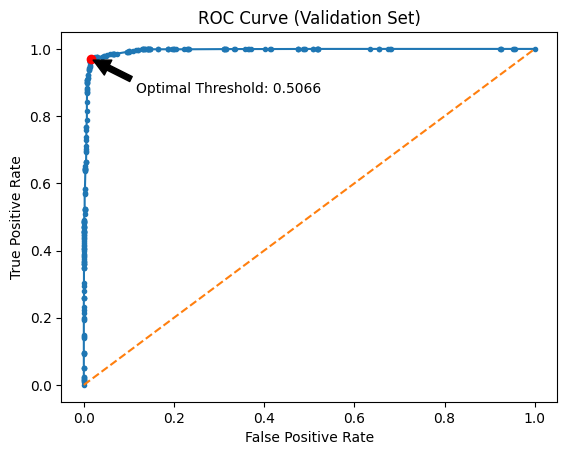


Test Set AUC: 0.9955318150737917

Test Set Results (First 10 rows):
       sensation_score  arousal_score   emotion_pca  true_sensation  \
27421           0.3750          0.353  5.551115e-17               0   
3858            0.3750          0.580  6.750835e-01               0   
29191           0.1250          0.350  5.551115e-17               0   
15484           0.9375          0.680  4.268818e-01               1   
2325            0.7500          0.250  5.551115e-17               0   
4519            0.8750          0.250  4.167683e-01               1   
25322           1.0000          0.455  3.493763e-01               1   
3498            1.0000          0.710  7.330043e-01               1   
22478           0.1875          0.353  5.551115e-17               0   
9644            1.0000          0.921  3.898502e-01               1   

       combined_score  predicted_sensation  
27421        0.467766                    0  
3858         0.467225                    0  
29191        0

['/content/drive/My Drive/training_0726/adaboost_model.joblib']

In [ ]:
df_threshold = df_original.copy()

# data preprocessing
df_threshold['arousal'] = df_threshold['arousal'].map({'Yes': 1, 'No': 0})

emotions = ['joy', 'surprise', 'anticipation', 'trust', 'anger', 'fear', 'sadness', 'disgust', 'neutral']
for emotion in emotions:
    df_threshold[emotion] = df_threshold['emotion'].apply(lambda x: 1 if emotion in x else 0)

emotion_data = df_threshold[emotions]

pca = PCA(n_components=1)
principal_component = pca.fit_transform(emotion_data)
df_threshold['emotion_pca'] = principal_component

scaler = MinMaxScaler()
df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']] = scaler.fit_transform(df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']])

# features and target variables
X = df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']]
y = df_threshold['sensation']

# data split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Adaboost
base_estimator = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# best threshold on validation set
val_predictions = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, val_predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# final evaluation on test set
test_predictions = model.predict_proba(X_test)[:, 1]
test_predictions_binary = (test_predictions >= optimal_threshold).astype(int)

print("\nTest Set Evaluation:")
print(classification_report(y_test, test_predictions_binary))

# ROC curve with best threshold
plt.figure()
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')

optimal_fpr, optimal_tpr = fpr[optimal_idx], tpr[optimal_idx]
plt.plot(optimal_fpr, optimal_tpr, 'ro')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.4f}',
             xy=(optimal_fpr, optimal_tpr),
             xytext=(optimal_fpr + 0.1, optimal_tpr - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# AUC of test set
test_auc = roc_auc_score(y_test, test_predictions)
print(f"\nTest Set AUC: {test_auc}")

# apply combined scores on the test set
df_test = pd.DataFrame(X_test, columns=['sensation_score', 'arousal_score', 'emotion_pca'])
df_test['true_sensation'] = y_test
df_test['combined_score'] = test_predictions
df_test['predicted_sensation'] = test_predictions_binary

print("\nTest Set Results (First 10 rows):")
print(df_test.head(10))

# save best XGBoost threshold and model
joblib.dump(optimal_threshold, f'{base_dir}/ADAoptimal_threshold.joblib')
joblib.dump(model, f'{base_dir}/adaboost_model.joblib')

## CATBoost: Calculate threshold by using arousal score and by using PCA on emotions

Optimal Threshold: 0.47474399083407737

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3243
           1       0.98      0.97      0.98      2842

    accuracy                           0.98      6085
   macro avg       0.98      0.98      0.98      6085
weighted avg       0.98      0.98      0.98      6085



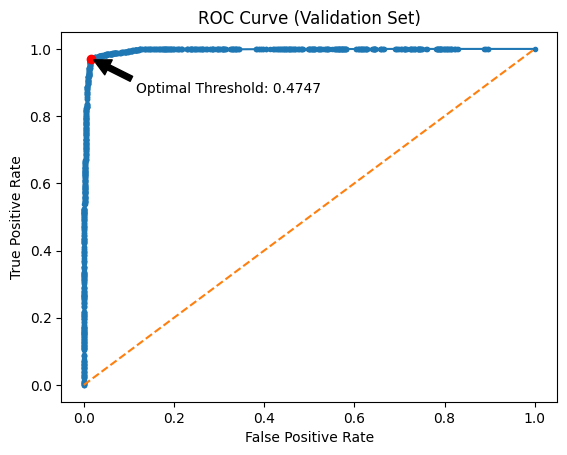


Test Set AUC: 0.9957597731746373

Test Set Results (First 10 rows):
       sensation_score  arousal_score   emotion_pca  true_sensation  \
27421           0.3750          0.353  3.330669e-16               0   
3858            0.3750          0.580  6.750835e-01               0   
29191           0.1250          0.350  3.330669e-16               0   
15484           0.9375          0.680  4.268818e-01               1   
2325            0.7500          0.250  3.330669e-16               0   
4519            0.8750          0.250  4.167683e-01               1   
25322           1.0000          0.455  3.493763e-01               1   
3498            1.0000          0.710  7.330043e-01               1   
22478           0.1875          0.353  3.330669e-16               0   
9644            1.0000          0.921  3.898502e-01               1   

       combined_score  predicted_sensation  
27421        0.002866                    0  
3858         0.005327                    0  
29191        0

In [ ]:
df_threshold = df_original.copy()

# data preprocessing
df_threshold['arousal'] = df_threshold['arousal'].map({'Yes': 1, 'No': 0})

emotions = ['joy', 'surprise', 'anticipation', 'trust', 'anger', 'fear', 'sadness', 'disgust', 'neutral']
for emotion in emotions:
    df_threshold[emotion] = df_threshold['emotion'].apply(lambda x: 1 if emotion in x else 0)

emotion_data = df_threshold[emotions]

pca = PCA(n_components=1)
principal_component = pca.fit_transform(emotion_data)
df_threshold['emotion_pca'] = principal_component

scaler = MinMaxScaler()
df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']] = scaler.fit_transform(df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']])

# features and target variables
X = df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']]
y = df_threshold['sensation']

# data split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# CatBoost
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=False)
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=20, verbose=False)

# best threshold on validation set
val_predictions = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, val_predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# final evaluation on test set
test_predictions = model.predict_proba(X_test)[:, 1]
test_predictions_binary = (test_predictions >= optimal_threshold).astype(int)

print("\nTest Set Evaluation:")
print(classification_report(y_test, test_predictions_binary))

# ROC curve with best threshold
plt.figure()
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')

optimal_fpr, optimal_tpr = fpr[optimal_idx], tpr[optimal_idx]
plt.plot(optimal_fpr, optimal_tpr, 'ro')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.4f}',
             xy=(optimal_fpr, optimal_tpr),
             xytext=(optimal_fpr + 0.1, optimal_tpr - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# AUC of test set
test_auc = roc_auc_score(y_test, test_predictions)
print(f"\nTest Set AUC: {test_auc}")

# apply combined scores on the test set
df_test = pd.DataFrame(X_test, columns=['sensation_score', 'arousal_score', 'emotion_pca'])
df_test['true_sensation'] = y_test
df_test['combined_score'] = test_predictions
df_test['predicted_sensation'] = test_predictions_binary

print("\nTest Set Results (First 10 rows):")
print(df_test.head(10))

# save best CatBoost threshold and model
joblib.dump(optimal_threshold, f'{base_dir}/CAToptimal_threshold.joblib')
model.save_model(f'{base_dir}/catboost_model.cbm')

# print feature importance
feature_importance = model.get_feature_importance()
feature_names = X.columns
for score, name in sorted(zip(feature_importance, feature_names), reverse=True):
    print(f"{name}: {score}")

## Random Forest: Calculate threshold by using arousal score and by using PCA on emotions

Optimal Threshold: 0.549111111111111

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3243
           1       0.98      0.97      0.97      2842

    accuracy                           0.98      6085
   macro avg       0.98      0.98      0.98      6085
weighted avg       0.98      0.98      0.98      6085



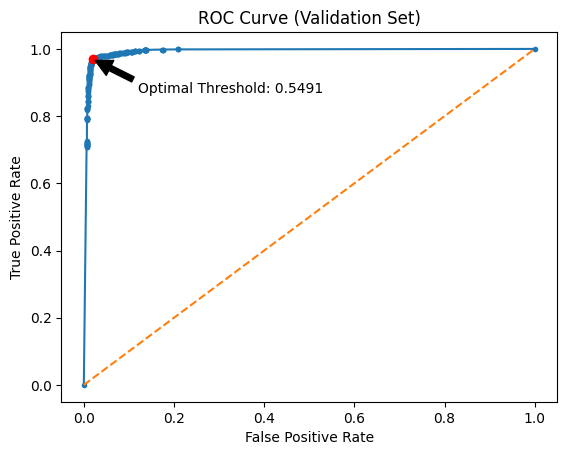


Test Set AUC: 0.9926889573016358

Test Set Results (First 10 rows):
       sensation_score  arousal_score   emotion_pca  true_sensation  \
27421           0.3750          0.353  5.551115e-17               0   
3858            0.3750          0.580  6.750835e-01               0   
29191           0.1250          0.350  5.551115e-17               0   
15484           0.9375          0.680  4.268818e-01               1   
2325            0.7500          0.250  5.551115e-17               0   
4519            0.8750          0.250  4.167683e-01               1   
25322           1.0000          0.455  3.493763e-01               1   
3498            1.0000          0.710  7.330043e-01               1   
22478           0.1875          0.353  5.551115e-17               0   
9644            1.0000          0.921  3.898502e-01               1   

       combined_score  predicted_sensation  
27421        0.003647                    0  
3858         0.000000                    0  
29191        0

['/content/drive/My Drive/training_0726/random_forest_threshold_model.joblib']

In [ ]:
df_threshold = df_original.copy()

# data preprocessing
df_threshold['arousal'] = df_threshold['arousal'].map({'Yes': 1, 'No': 0})

emotions = ['joy', 'surprise', 'anticipation', 'trust', 'anger', 'fear', 'sadness', 'disgust', 'neutral']
for emotion in emotions:
    df_threshold[emotion] = df_threshold['emotion'].apply(lambda x: 1 if emotion in x else 0)

emotion_data = df_threshold[emotions]

pca = PCA(n_components=1)
principal_component = pca.fit_transform(emotion_data)
df_threshold['emotion_pca'] = principal_component

scaler = MinMaxScaler()
df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']] = scaler.fit_transform(df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']])

# features and target variables
X = df_threshold[['sensation_score', 'arousal_score', 'emotion_pca']]
y = df_threshold['sensation']

# data split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# best threshold on validation set
val_predictions = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, val_predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# final evaluation on test set
test_predictions = model.predict_proba(X_test)[:, 1]
test_predictions_binary = (test_predictions >= optimal_threshold).astype(int)

print("\nTest Set Evaluation:")
print(classification_report(y_test, test_predictions_binary))

# ROC curve with best threshold
plt.figure()
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')

optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]
plt.plot(optimal_fpr, optimal_tpr, 'ro')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.4f}',
             xy=(optimal_fpr, optimal_tpr),
             xytext=(optimal_fpr + 0.1, optimal_tpr - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# ROC curve with best threshold
test_auc = roc_auc_score(y_test, test_predictions)
print(f"\nTest Set AUC: {test_auc}")

# save best CatBoost threshold and model
df_test = pd.DataFrame(X_test, columns=['sensation_score', 'arousal_score', 'emotion_pca'])
df_test['true_sensation'] = y_test
df_test['combined_score'] = test_predictions
df_test['predicted_sensation'] = test_predictions_binary

print("\nTest Set Results (First 10 rows):")
print(df_test.head(10))

# final evaluation on test set
base_dir = '/content/drive/My Drive/training_0726'
joblib.dump(optimal_threshold, f'{base_dir}/RF_optimal_threshold.joblib')
joblib.dump(model, f'{base_dir}/random_forest_threshold_model.joblib')

# Training Function

## XGBoost

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

def prepare_data():
    # read the df_4grams_syntactic data
    df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv')

    # read the df_selected_features
    df_selected_features = pd.read_csv(f'{base_dir}/df_selected_features.csv')

    # get the indices of selected features
    selected_indices = df_selected_features['Index'].tolist()

    # set features and target variable
    X = df_4grams_syntactic.iloc[:, selected_indices]
    y = df_4grams_syntactic['sensation']

    # define columns to exclude
    exclude_columns = ['headline', 'clickbait', 'sensation_score',
                       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                       'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                       'ner_features', 'pos_freq', 'dep_tags', 'sensation']

    # remove non-numeric columns and excluded columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    valid_columns = [col for col in numeric_columns if col not in exclude_columns]
    X = X[valid_columns]

    # save the names of the original features
    original_feature_names = X.columns.tolist()
    joblib.dump(original_feature_names, f'{base_dir}/feature_names.joblib')

    # split the dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    # create a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns)
        ])

    # preprocess the training set only
    X_train_processed = preprocessor.fit_transform(X_train)

    # apply SMOTE after preprocessing
    smote = SMOTE(random_state=42)
    X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train)

    # independently preprocess the validation and test sets (transform only)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val, y_test, preprocessor

In [ ]:
%%time

# prepare data
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data()

# XGBoost
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_dist_xgb = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_xg = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=100,
    cv=kfold,
    n_jobs=-1,
    verbose=2,
    scoring='f1',
    random_state=42
)

# fitting on preprocessed training data
random_search_xg.fit(X_train, y_train)

print("best parameters:", random_search_xg.best_params_)
print("best cross-validation score:", random_search_xg.best_score_)

# use the best model for predictions
best_model = random_search_xg.best_estimator_
y_val_pred = best_model.predict(X_val)

# classification report
print("\nclassification report:")
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:55:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
best cross-validation score: 0.6634232268949644

classification report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      3223
           1       0.63      0.64      0.64      2862

    accuracy                           0.66      6085
   macro avg       0.66      0.66      0.66      6085
weighted avg       0.66      0.66      0.66      6085

CPU times: user 15min 25s, sys: 47.4 s, total: 16min 13s
Wall time: 21min 27s


### ROC AUC

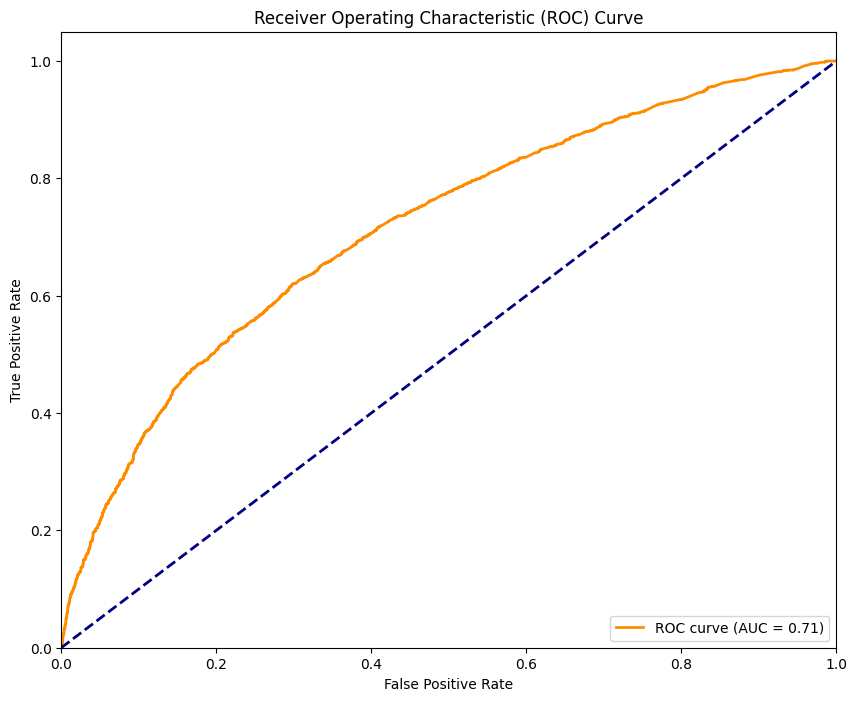

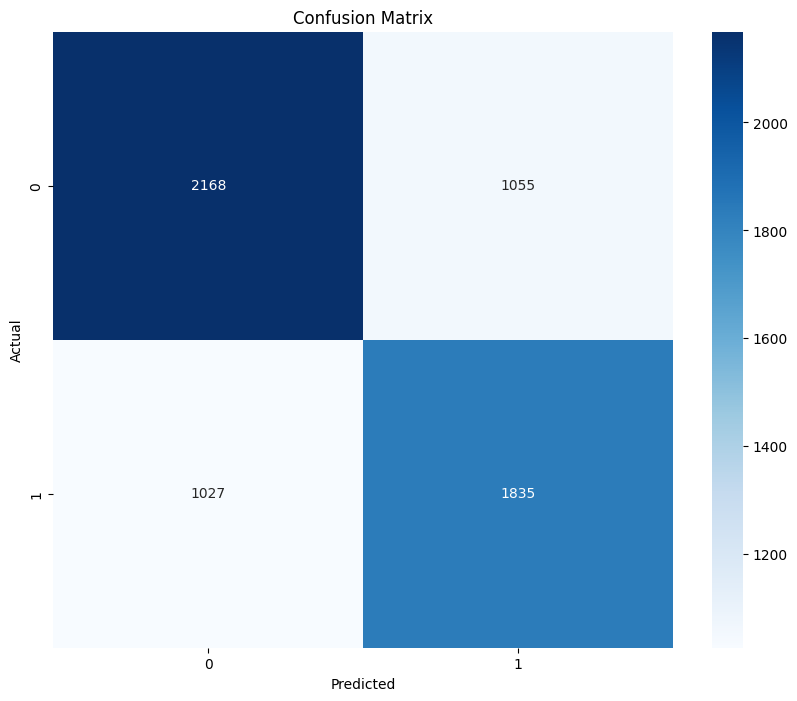

Accuracy: 0.6578
Precision: 0.6349
Recall: 0.6412
F1 Score: 0.6380


In [ ]:
# calculate the predicted probability of the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# save model information
best_params = random_search_xg.best_params_
best_score = random_search_xg.best_score_
joblib.dump(best_params, f'{base_dir}/xgboost_best_params.joblib')
joblib.dump(best_score, f'{base_dir}/xgboost_best_score.joblib')

# save the best model
joblib.dump(best_model, f'{base_dir}/xgboost_best_model.joblib')

# save a subset of the training set for SHAP analysis
X_train_sample = X_train[:2000]  # adjust sample size as needed
joblib.dump(X_train_sample, f'{base_dir}/xgboost_X_train_sample.joblib')

# save feature names
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, f'{base_dir}/xgboost_feature_names.joblib')

# save preprocessor
joblib.dump(preprocessor, f'{base_dir}/xgboost_preprocessor.joblib')

# # delete variables
# del X_train, X_val, X_test, y_train, y_val, y_test
# del random_search_xg
# del y_val_pred_proba, y_val_pred
# del fpr, tpr

# # clear matplotlib plot
# plt.close('all')

# # GC
# gc.collect()

# # check memory usage
# print(f"memory usage: {psutil.virtual_memory().percent}%")

['/content/drive/My Drive/training_0726/xgboost_preprocessor.joblib']

## XGBoost with Superlative adjective words list

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

def prepare_data():
    # read the df_4grams_syntactic data
    df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv')

    # read the df_selected_features
    df_selected_features = pd.read_csv(f'{base_dir}/df_selected_features.csv')

    # get the indices of selected features
    selected_indices = df_selected_features['Index'].tolist()

    # set features and target variable
    X = df_4grams_syntactic.iloc[:, selected_indices]
    y = df_4grams_syntactic['sensation']

    # Read superlative_list.csv
    superlative_df = pd.read_csv(f'{base_dir}/superlative_list.csv')
    superlative_list = superlative_df['Superlative'].tolist()

    # Count superlatives in headlines
    df_4grams_syntactic['superlative_count'] = df_4grams_syntactic['headline'].apply(
        lambda x: sum(1 for word in x.lower().split() if word in superlative_list)
    )

    # Add 'superlative_count' to X
    X['superlative_count'] = df_4grams_syntactic['superlative_count']

    # define columns to exclude
    exclude_columns = ['headline', 'clickbait', 'sensation_score',
                       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                       'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                       'ner_features', 'pos_freq', 'dep_tags', 'sensation']

    # remove non-numeric columns and excluded columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    valid_columns = [col for col in numeric_columns if col not in exclude_columns]
    X = X[valid_columns]

    # save the names of the original features
    original_feature_names = X.columns.tolist()
    joblib.dump(original_feature_names, f'{base_dir}/feature_names.joblib')

    # split the dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    # create a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns)
        ])

    # preprocess the training set only
    X_train_processed = preprocessor.fit_transform(X_train)

    # apply SMOTE after preprocessing
    smote = SMOTE(random_state=42)
    X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train)

    # independently preprocess the validation and test sets (transform only)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val, y_test, preprocessor

In [ ]:
%%time

# prepare data
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data()

# XGBoost
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_dist_xgb = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_xg = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=100,
    cv=kfold,
    n_jobs=-1,
    verbose=2,
    scoring='f1',
    random_state=42
)

# fitting on preprocessed training data
random_search_xg.fit(X_train, y_train)

print("best parameters:", random_search_xg.best_params_)
print("best cross-validation score:", random_search_xg.best_score_)

# use the best model for predictions
best_model = random_search_xg.best_estimator_
y_val_pred = best_model.predict(X_val)

# classification report
print("\nclassification report:")
print(classification_report(y_val, y_val_pred))

<ipython-input-12-220da103c41d>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['superlative_count'] = df_4grams_syntactic['superlative_count']


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:17:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
best cross-validation score: 0.6644156657481959

classification report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      3223
           1       0.64      0.65      0.64      2862

    accuracy                           0.66      6085
   macro avg       0.66      0.66      0.66      6085
weighted avg       0.66      0.66      0.66      6085

CPU times: user 14min 49s, sys: 40.8 s, total: 15min 30s
Wall time: 21min 39s


### ROC AUC

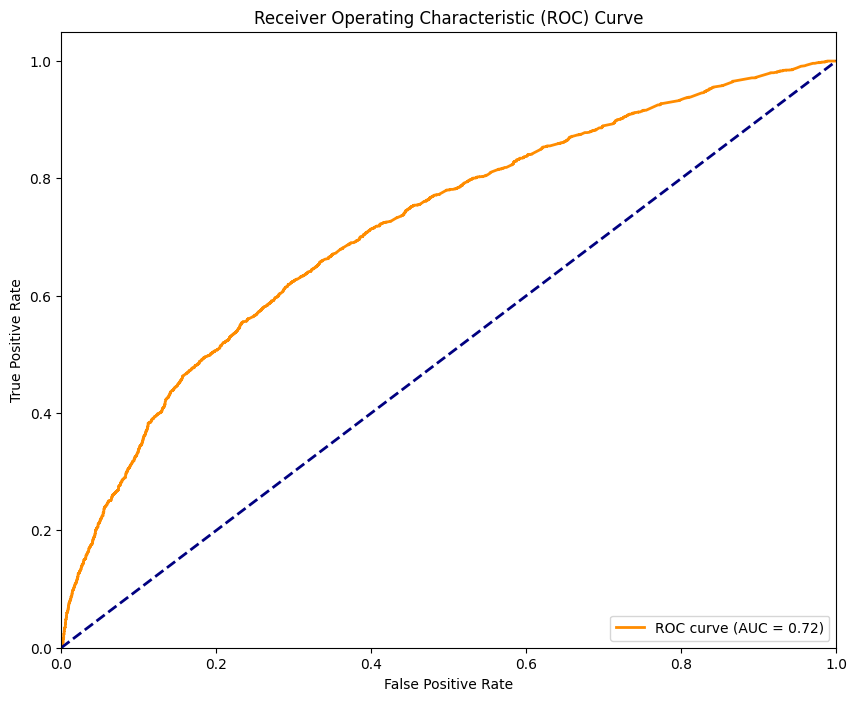

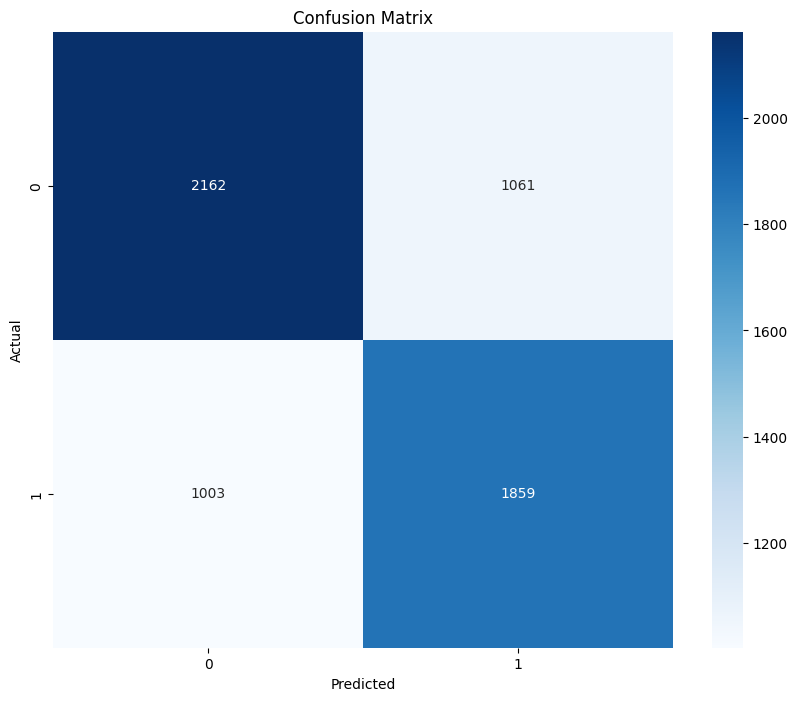

Accuracy: 0.6608
Precision: 0.6366
Recall: 0.6495
F1 Score: 0.6430


In [ ]:
# calculate the predicted probability of the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# save model information
best_params = random_search_xg.best_params_
best_score = random_search_xg.best_score_
joblib.dump(best_params, f'{base_dir}/xgboost_super_best_params.joblib')
joblib.dump(best_score, f'{base_dir}/xgboost_super_best_score.joblib')

# save the best model
joblib.dump(best_model, f'{base_dir}/xgboost_super_best_model.joblib')

# save a subset of the training set for SHAP analysis
X_train_sample = X_train[:2000]  # adjust sample size as needed
joblib.dump(X_train_sample, f'{base_dir}/xgboost_super_X_train_sample.joblib')

# save feature names
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, f'{base_dir}/xgboost_super_feature_names.joblib')

# save preprocessor
joblib.dump(preprocessor, f'{base_dir}/xgboost_super_preprocessor.joblib')

# # delete variables
# del X_train, X_val, X_test, y_train, y_val, y_test
# del random_search_xg
# del y_val_pred_proba, y_val_pred
# del fpr, tpr

# # clear matplotlib plot
# plt.close('all')

# # GC
# gc.collect()

# # check memory usage
# print(f"memory usage: {psutil.virtual_memory().percent}%")

['/content/drive/My Drive/training_0726/xgboost_super_preprocessor.joblib']

## XGBoost with Threshold

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

def prepare_data():
    # read the df_4grams_syntactic data
    df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv')

    # read the df_selected_features
    df_selected_features = pd.read_csv(f'{base_dir}/df_selected_features.csv')

    # get the indices of selected features
    selected_indices = df_selected_features['Index'].tolist()

    # set features and target variable
    X = df_4grams_syntactic.iloc[:, selected_indices]
    y = df_4grams_syntactic['sensation']

    # define columns to exclude
    exclude_columns = ['headline', 'clickbait', 'sensation_score',
                       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                       'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                       'ner_features', 'pos_freq', 'dep_tags', 'sensation']

    # remove non-numeric columns and excluded columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    valid_columns = [col for col in numeric_columns if col not in exclude_columns]
    X = X[valid_columns]

    # save the names of the original features
    original_feature_names = X.columns.tolist()
    joblib.dump(original_feature_names, f'{base_dir}/feature_names.joblib')

    # split the dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    # create a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns)
        ])

    # preprocess the training set only
    X_train_processed = preprocessor.fit_transform(X_train)

    # apply SMOTE after preprocessing
    smote = SMOTE(random_state=42)
    X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train)

    # independently preprocess the validation and test sets (transform only)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val, y_test, preprocessor

In [ ]:
%%time

# prepare data
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data()

# XGBoost
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_dist_xgb = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_xg = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=100,
    cv=kfold,
    n_jobs=-1,
    verbose=2,
    scoring='f1',
    random_state=42
)

# fitting on preprocessed training data
random_search_xg.fit(X_train, y_train)

print("best parameters:", random_search_xg.best_params_)
print("best cross-validation score:", random_search_xg.best_score_)

# use the best model for predictions
best_model = random_search_xg.best_estimator_
# y_val_pred = best_model.predict(X_val)

# # classification report
# print("\nclassification report:")
# print(classification_report(y_val, y_val_pred))

# load the custom threshold
base_dir = '/content/drive/My Drive/training_0726'
optimal_threshold = joblib.load(f'{base_dir}/XGoptimal_threshold.joblib')

# use the optimal threshold
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)
print(f"\nValidation set classification report using optimal threshold ({optimal_threshold:.4f}):")
print(classification_report(y_val, y_val_pred))

# # predict on test set
# y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
# y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)
# print(f"\nTest set classification report using optimal threshold ({optimal_threshold:.4f}):")
# print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:38:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
best cross-validation score: 0.6634232268949644

Validation set classification report using optimal threshold (0.4457):
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      3223
           1       0.61      0.72      0.66      2862

    accuracy                           0.65      6085
   macro avg       0.65      0.65      0.65      6085
weighted avg       0.66      0.65      0.65      6085

CPU times: user 14min 42s, sys: 39.2 s, total: 15min 21s
Wall time: 21min 32s


### ROC AUC

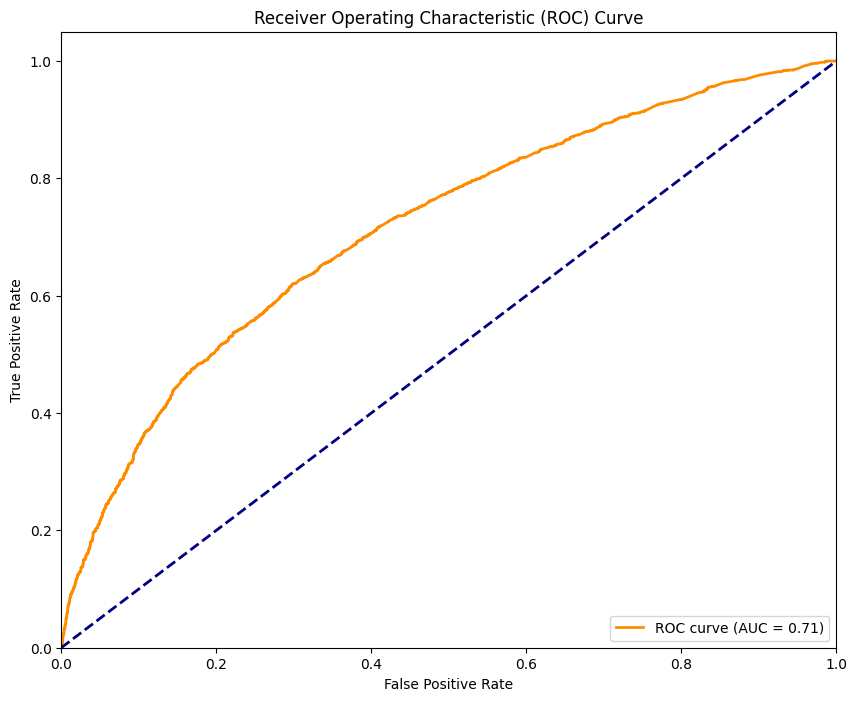

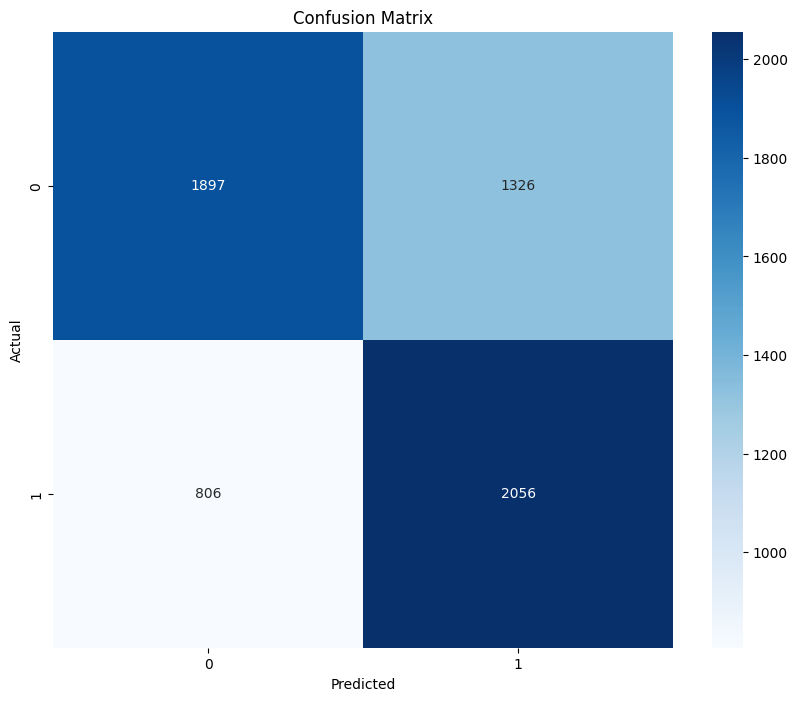

Accuracy: 0.6496
Precision: 0.6079
Recall: 0.7184
F1 Score: 0.6586


In [ ]:
# calculate the predicted probability of the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# save model information
best_params = random_search_xg.best_params_
best_score = random_search_xg.best_score_
joblib.dump(best_params, f'{base_dir}/xgboost_thres_best_params.joblib')
joblib.dump(best_score, f'{base_dir}/xgboost_thres_best_score.joblib')

# save the best model
joblib.dump(best_model, f'{base_dir}/xgboost_thres_best_model.joblib')

# save a subset of the training set for SHAP analysis
X_train_sample = X_train[:2000]  # adjust sample size as needed
joblib.dump(X_train_sample, f'{base_dir}/xgboost_thres_X_train_sample.joblib')

# save feature names
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, f'{base_dir}/xgboost_thres_feature_names.joblib')

# save preprocessor
joblib.dump(preprocessor, f'{base_dir}/xgboost_thres_preprocessor.joblib')

# save the optimal threshold
joblib.dump(optimal_threshold, f'{base_dir}/xgboost_optimal_threshold.joblib')

['/content/drive/My Drive/training_0726/xgboost_optimal_threshold.joblib']

## XGBoost with Superlative adjective words list and threshold

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

def prepare_data():
    # read data
    df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv')
    df_selected_features = pd.read_csv(f'{base_dir}/df_selected_features.csv')
    superlative_df = pd.read_csv(f'{base_dir}/superlative_list.csv')
    superlative_list = superlative_df['Superlative'].tolist()

    # get indices of selected features
    selected_indices = df_selected_features['Index'].tolist()

    # set features and target variable
    X = df_4grams_syntactic.iloc[:, selected_indices]
    y = df_4grams_syntactic['sensation']

    # calculate number of superlative adjectives
    df_4grams_syntactic['superlative_count'] = df_4grams_syntactic['headline'].apply(
        lambda x: sum(1 for word in str(x).lower().split() if word in superlative_list)
    )

    # add 'superlative_count' to X
    X['superlative_count'] = df_4grams_syntactic['superlative_count']

    # define columns to exclude
    exclude_columns = ['headline', 'clickbait', 'sensation_score',
                       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                       'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                       'ner_features', 'pos_freq', 'dep_tags', 'sensation']

    # remove non-numeric columns and excluded columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    valid_columns = [col for col in numeric_columns if col not in exclude_columns]
    X = X[valid_columns]

    # save original feature names
    original_feature_names = X.columns.tolist()
    joblib.dump(original_feature_names, f'{base_dir}/feature_names.joblib')

    # split dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    # create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns)
        ])

    # preprocess training set
    X_train_processed = preprocessor.fit_transform(X_train)

    # apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train)

    # preprocess validation and test sets
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val, y_test, preprocessor, original_feature_names

In [ ]:
# prepare data
X_train, X_val, _, y_train, y_val, _, preprocessor, feature_names = prepare_data()

# xgboost
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_dist_xgb = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_xg = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=100,
    cv=kfold,
    n_jobs=-1,
    verbose=2,
    scoring='f1',
    random_state=42
)

# fit on preprocessed training data
random_search_xg.fit(X_train, y_train)

print("Best parameters:", random_search_xg.best_params_)
print("Best cross-validation score:", random_search_xg.best_score_)

# use best model for predictions
best_model = random_search_xg.best_estimator_

# Load the optimal threshold
optimal_threshold = joblib.load(f'{base_dir}/XGoptimal_threshold.joblib')

# Make predictions on validation set using the optimal threshold
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)

# classification report for validation set
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# Print the optimal threshold
print(f"\nOptimal Threshold: {optimal_threshold}")

<ipython-input-7-363aff46666d>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['superlative_count'] = df_4grams_syntactic['superlative_count']


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:06:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation score: 0.6644156657481959

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      3223
           1       0.61      0.72      0.66      2862

    accuracy                           0.65      6085
   macro avg       0.66      0.65      0.65      6085
weighted avg       0.66      0.65      0.65      6085


Optimal Threshold: 0.4457232654094696


### ROC AUC

<ipython-input-7-363aff46666d>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['superlative_count'] = df_4grams_syntactic['superlative_count']


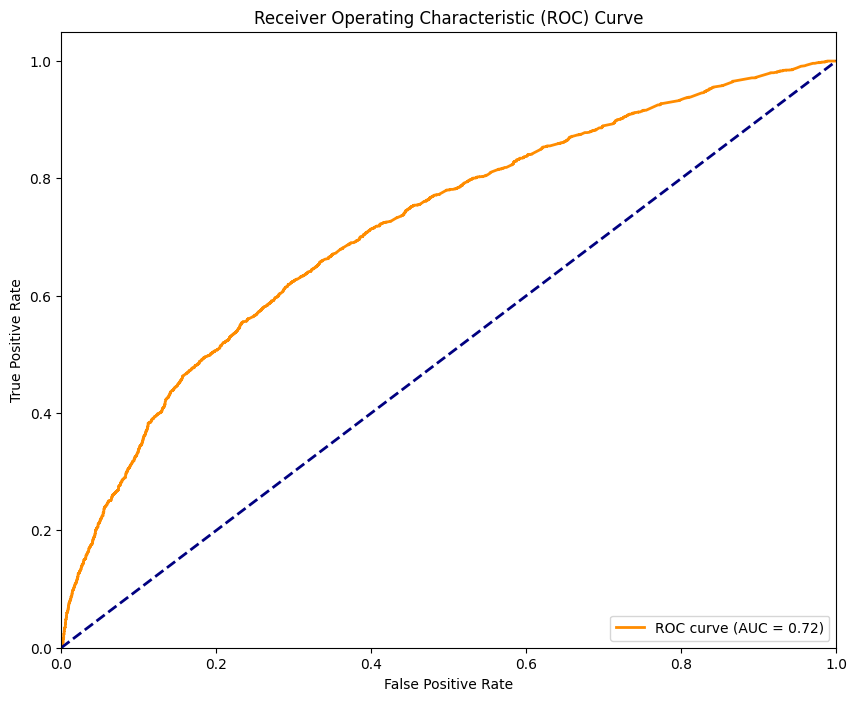

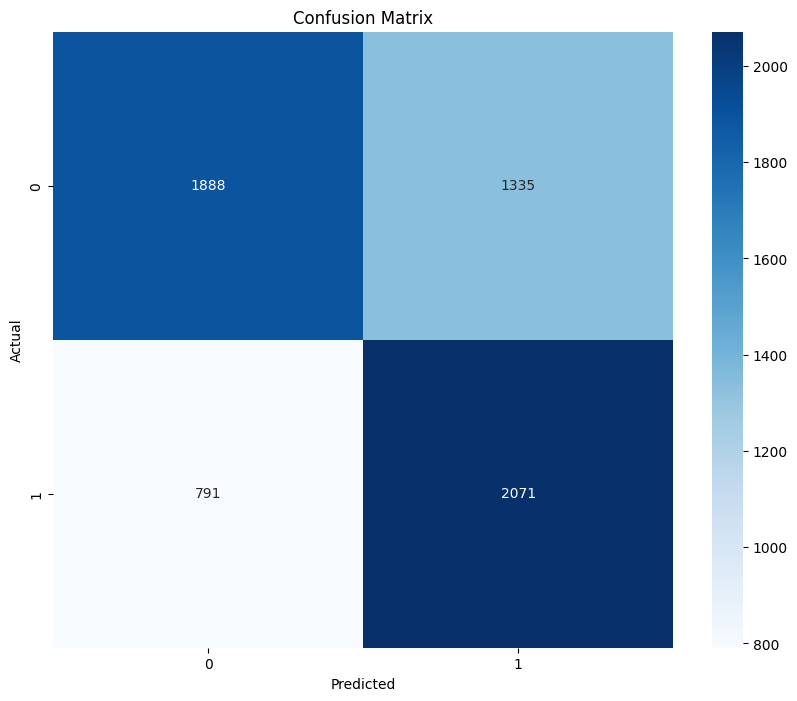

Accuracy: 0.6506
Precision: 0.6080
Recall: 0.7236
F1 Score: 0.6608

Optimal Threshold: 0.4457232654094696


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# Prepare data
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor, _ = prepare_data()

# Use the best model from the previous run
best_model = random_search_xg.best_estimator_

# Calculate predicted probabilities for the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Make predictions using the optimal threshold
y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print optimal threshold
print(f"\nOptimal Threshold: {optimal_threshold}")

In [ ]:
# Specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# Save model information
best_params = random_search_xg.best_params_
best_score = random_search_xg.best_score_
joblib.dump(best_params, f'{base_dir}/xgboost_best_params.joblib')
joblib.dump(best_score, f'{base_dir}/xgboost_best_score.joblib')

# Save the best model
best_model = random_search_xg.best_estimator_
joblib.dump(best_model, f'{base_dir}/xgboost_best_model.joblib')

# Save a subset of the training set for SHAP analysis
X_train_sample = X_train[:2000]  # Adjust sample size as needed
joblib.dump(X_train_sample, f'{base_dir}/xgboost_X_train_sample.joblib')

# Save feature names
joblib.dump(feature_names, f'{base_dir}/xgboost_feature_names.joblib')

# Save preprocessor
joblib.dump(preprocessor, f'{base_dir}/xgboost_preprocessor.joblib')

# Save optimal threshold
joblib.dump(optimal_threshold, f'{base_dir}/XGoptimal_threshold.joblib')

['/content/drive/My Drive/training_0726/XGoptimal_threshold.joblib']

## AdaBoost

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

def prepare_data():
    # read the df_4grams_syntactic data
    df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv')

    # read the df_selected_features
    df_selected_features = pd.read_csv(f'{base_dir}/df_selected_features.csv')

    # get the indices of selected features
    selected_indices = df_selected_features['Index'].tolist()

    # set features and target variable
    X = df_4grams_syntactic.iloc[:, selected_indices]
    y = df_4grams_syntactic['sensation']

    # define columns to exclude
    exclude_columns = ['headline', 'clickbait', 'sensation_score',
                       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                       'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                       'ner_features', 'pos_freq', 'dep_tags', 'sensation']

    # remove non-numeric columns and excluded columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    valid_columns = [col for col in numeric_columns if col not in exclude_columns]
    X = X[valid_columns]

    # save the names of the original features
    original_feature_names = X.columns.tolist()
    joblib.dump(original_feature_names, f'{base_dir}/feature_names.joblib')

    # split the dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    # create a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns)
        ])

    # preprocess the training set only
    X_train_processed = preprocessor.fit_transform(X_train)

    # apply SMOTE after preprocessing
    smote = SMOTE(random_state=42)
    X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train)

    # independently preprocess the validation and test sets (transform only)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val, y_test, preprocessor

In [ ]:
%%time
# prepare data
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data()

# AdaBoost
base_estimator = DecisionTreeClassifier()
adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

param_dist_ada = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'base_estimator__max_depth': [3, 6, 9],
    'base_estimator__min_weight_fraction_leaf': [0, 0.1],  # similar to min_child_weight
    'base_estimator__max_features': [0.8, 1.0],  # similar to colsample_bytree
    'algorithm': ['SAMME', 'SAMME.R']  # AdaBoost specific parameters
}

# Randomized Search CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_ada = RandomizedSearchCV(
    estimator=adaboost_classifier,
    param_distributions=param_dist_ada,
    n_iter=100,
    cv=kfold,
    n_jobs=-1,
    verbose=2,
    scoring='f1',
    random_state=42
)

# fitting on preprocessed training data
random_search_ada.fit(X_train, y_train)

print("best parameters:", random_search_ada.best_params_)
print("best cross-validation score:", random_search_ada.best_score_)

# use the best model for predictions
best_model = random_search_ada.best_estimator_
y_val_pred = best_model.predict(X_val)

# classification report
print("\nvalidation set classification report:")
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


best parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'base_estimator__min_weight_fraction_leaf': 0, 'base_estimator__max_features': 1.0, 'base_estimator__max_depth': 3, 'algorithm': 'SAMME.R'}
best cross-validation score: 0.6658196625136333

validation set classification report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      3223
           1       0.62      0.66      0.64      2862

    accuracy                           0.65      6085
   macro avg       0.65      0.65      0.65      6085
weighted avg       0.65      0.65      0.65      6085

CPU times: user 16min 32s, sys: 1min 2s, total: 17min 35s
Wall time: 2h 35min 21s


### ROC AUC

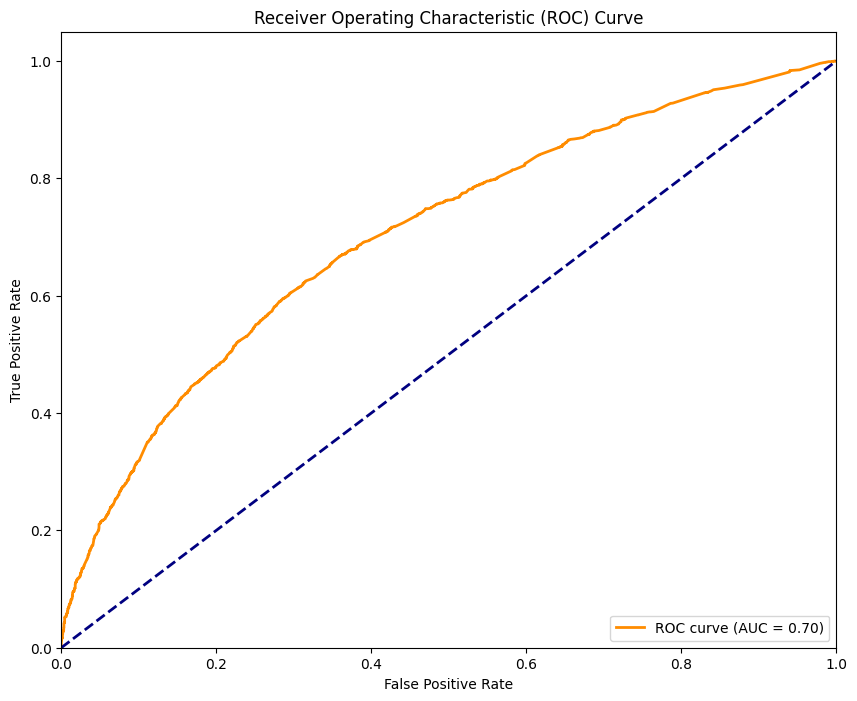

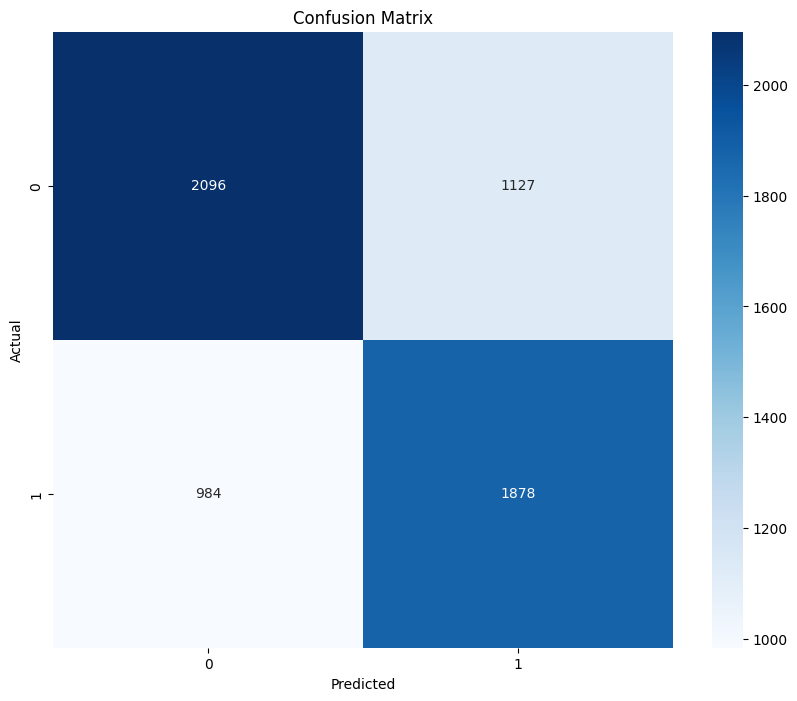

Accuracy: 0.6531
Precision: 0.6250
Recall: 0.6562
F1 Score: 0.6402


In [ ]:
# calculate the predicted probability of the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# save model information
best_params = random_search_ada.best_params_
best_score = random_search_ada.best_score_
joblib.dump(best_params, f'{base_dir}/adaboost_best_params.joblib')
joblib.dump(best_score, f'{base_dir}/adaboost_best_score.joblib')

# save the best model
joblib.dump(best_model, f'{base_dir}/adaboost_best_model.joblib')

# save a subset of the training set for SHAP analysis
X_train_sample = X_train[:2000]  # adjust sample size as needed
joblib.dump(X_train_sample, f'{base_dir}/adaboost_X_train_sample.joblib')

# save feature names
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, f'{base_dir}/adaboost_feature_names.joblib')

# save preprocessor
joblib.dump(preprocessor, f'{base_dir}/adaboost_preprocessor.joblib')

['/content/drive/My Drive/training_0726/adaboost_preprocessor.joblib']

## CATBoost

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

def prepare_data():
    # read the df_4grams_syntactic data
    df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv')

    # read the df_selected_features
    df_selected_features = pd.read_csv(f'{base_dir}/df_selected_features.csv')

    # get the indices of selected features
    selected_indices = df_selected_features['Index'].tolist()

    # set features and target variable
    X = df_4grams_syntactic.iloc[:, selected_indices]
    y = df_4grams_syntactic['sensation']

    # define columns to exclude
    exclude_columns = ['headline', 'clickbait', 'sensation_score',
                       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                       'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                       'ner_features', 'pos_freq', 'dep_tags', 'sensation']

    # remove non-numeric columns and excluded columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    valid_columns = [col for col in numeric_columns if col not in exclude_columns]
    X = X[valid_columns]

    # save the names of the original features
    original_feature_names = X.columns.tolist()
    joblib.dump(original_feature_names, f'{base_dir}/feature_names.joblib')

    # split the dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    # create a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns)
        ])

    # preprocess the training set only
    X_train_processed = preprocessor.fit_transform(X_train)

    # apply SMOTE after preprocessing
    smote = SMOTE(random_state=42)
    X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train)

    # independently preprocess the validation and test sets (transform only)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val, y_test, preprocessor

In [ ]:
%%time
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data()

# CatBoost
catboost_classifier = CatBoostClassifier(random_state=42, verbose=False)

param_dist_cat = {
    'iterations': [100, 300, 500],  # n_estimators
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [3, 6, 9],  # max_depth
    'l2_leaf_reg': [1, 3],  # similar to min_child_weight
    'subsample': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],  # similar to colsample_bytree
    'random_strength': [0, 0.1]  # similar to gamma
}

# Randomized Search CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_cat = RandomizedSearchCV(
    estimator=catboost_classifier,
    param_distributions=param_dist_cat,
    n_iter=100,
    cv=kfold,
    n_jobs=-1,
    verbose=2,
    scoring='f1',
    random_state=42
)

# fitting on preprocessed training data
random_search_cat.fit(X_train, y_train)

print("best parameters:", random_search_cat.best_params_)
print("best cross-validation score:", random_search_cat.best_score_)

# use the best model for predictions
best_model = random_search_cat.best_estimator_
y_val_pred = best_model.predict(X_val)

# print classification report
print("\nvalidation set classification report:")
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best parameters: {'subsample': 0.8, 'random_strength': 0.1, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 9, 'colsample_bylevel': 1.0}
best cross-validation score: 0.6697000335964166

validation set classification report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      3223
           1       0.64      0.64      0.64      2862

    accuracy                           0.66      6085
   macro avg       0.66      0.66      0.66      6085
weighted avg       0.66      0.66      0.66      6085

CPU times: user 14min 19s, sys: 42.3 s, total: 15min 1s
Wall time: 58min 19s


### ROC AUC

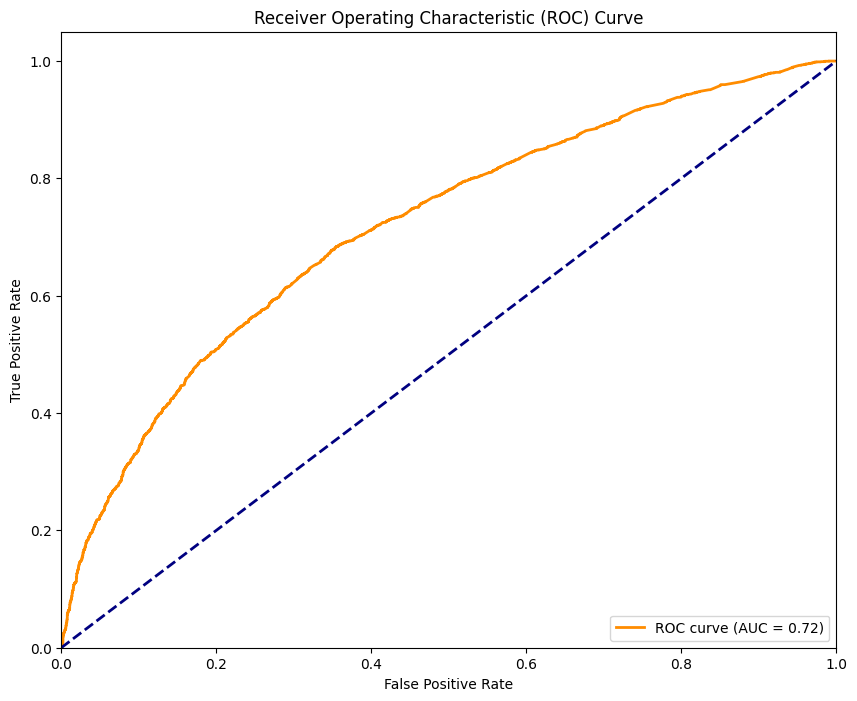

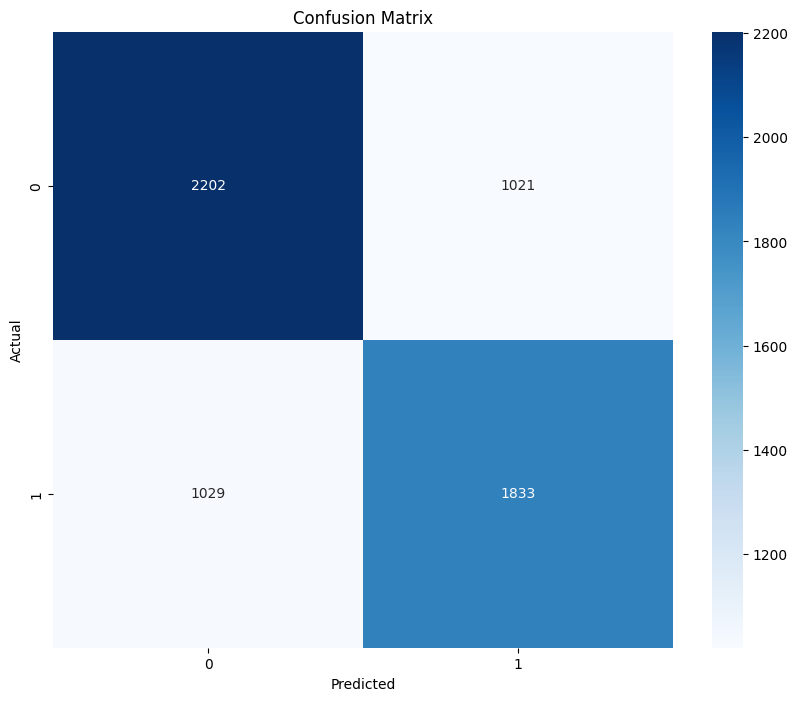

Accuracy: 0.6631
Precision: 0.6423
Recall: 0.6405
F1 Score: 0.6414


In [ ]:
# calculate the predicted probability of the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# save model information
best_params = random_search_cat.best_params_
best_score = random_search_cat.best_score_
joblib.dump(best_params, f'{base_dir}/catboost_best_params.joblib')
joblib.dump(best_score, f'{base_dir}/catboost_best_score.joblib')

# save the best model
joblib.dump(best_model, f'{base_dir}/catboost_best_model.joblib')

# save a subset of the training set for SHAP analysis
X_train_sample = X_train[:2000]  # adjust sample size as needed
joblib.dump(X_train_sample, f'{base_dir}/catboost_X_train_sample.joblib')

# save feature names
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, f'{base_dir}/catboost_feature_names.joblib')

# save preprocessor
joblib.dump(preprocessor, f'{base_dir}/catboost_preprocessor.joblib')

['/content/drive/My Drive/training_0726/catboost_preprocessor.joblib']

## Random Forest

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

def prepare_data():
    # read the df_4grams_syntactic data
    df_4grams_syntactic = pd.read_csv(f'{base_dir}/df_4grams_syntactic.csv')

    # read the df_selected_features
    df_selected_features = pd.read_csv(f'{base_dir}/df_selected_features.csv')

    # get the indices of selected features
    selected_indices = df_selected_features['Index'].tolist()

    # set features and target variable
    X = df_4grams_syntactic.iloc[:, selected_indices]
    y = df_4grams_syntactic['sensation']

    # define columns to exclude
    exclude_columns = ['headline', 'clickbait', 'sensation_score',
                       'sensation_reason', 'emotion', 'arousal', 'arousal_score',
                       'arousal_reason', 'pos_tags', 'ner_tags', 'pos_features',
                       'ner_features', 'pos_freq', 'dep_tags', 'sensation']

    # remove non-numeric columns and excluded columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    valid_columns = [col for col in numeric_columns if col not in exclude_columns]
    X = X[valid_columns]

    # save the names of the original features
    original_feature_names = X.columns.tolist()
    joblib.dump(original_feature_names, f'{base_dir}/feature_names.joblib')

    # split the dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

    # create a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.columns)
        ])

    # preprocess the training set only
    X_train_processed = preprocessor.fit_transform(X_train)

    # apply SMOTE after preprocessing
    smote = SMOTE(random_state=42)
    X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train)

    # independently preprocess the validation and test sets (transform only)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val, y_test, preprocessor

In [ ]:
%%time
# assume the prepare_data function is defined and available
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data()

# Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

param_dist_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [1, 3],  # similar to min_child_weight
    'max_features': [0.8, 1.0],  # similar to colsample_bytree
    'bootstrap': [True, False],  # similar to subsample
    'min_impurity_decrease': [0, 0.1]  # similar to gamma
}

# Randomized Search CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist_rf,
    n_iter=100,
    cv=kfold,
    n_jobs=-1,
    verbose=2,
    scoring='f1',
    random_state=42
)

# fitting on preprocessed training data
random_search_rf.fit(X_train, y_train)

print("best parameters:", random_search_rf.best_params_)
print("best cross-validation score:", random_search_rf.best_score_)

# use the best model for predictions
best_model = random_search_rf.best_estimator_
y_val_pred = best_model.predict(X_val)

# print classification report
print("\nvalidation set classification report:")
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best parameters: {'n_estimators': 500, 'min_samples_leaf': 3, 'min_impurity_decrease': 0, 'max_features': 1.0, 'max_depth': 3, 'bootstrap': True}
best cross-validation score: 0.6611619132764461

validation set classification report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62      3223
           1       0.59      0.70      0.64      2862

    accuracy                           0.63      6085
   macro avg       0.64      0.64      0.63      6085
weighted avg       0.64      0.63      0.63      6085

CPU times: user 15min 8s, sys: 44.1 s, total: 15min 52s
Wall time: 1h 13min 37s


### ROC AUC

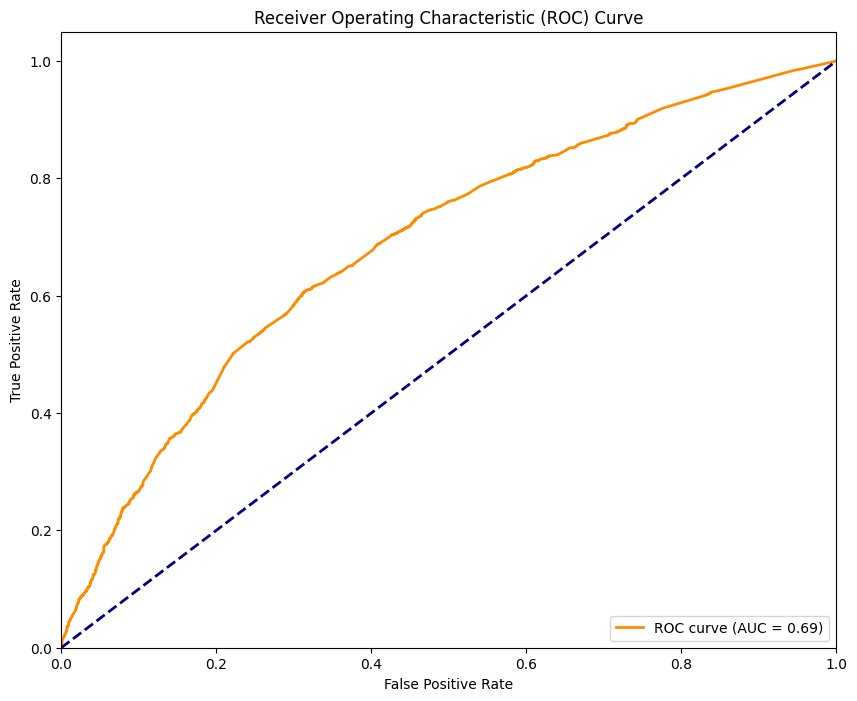

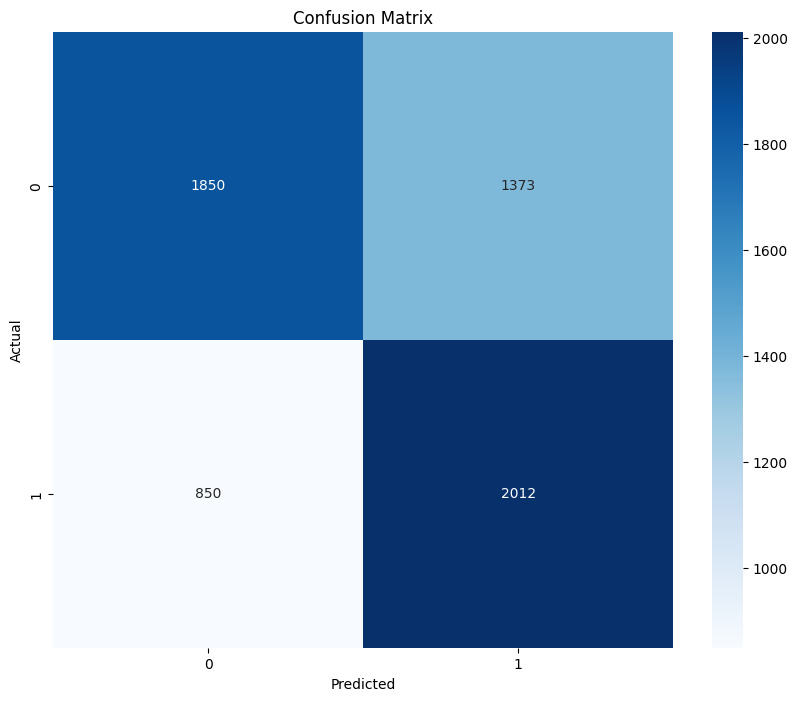

Accuracy: 0.6347
Precision: 0.5944
Recall: 0.7030
F1 Score: 0.6441


In [ ]:
# calculate the predicted probability of the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# specify the base directory path
base_dir = '/content/drive/My Drive/training_0726'

# save model information
best_params = random_search_rf.best_params_
best_score = random_search_rf.best_score_
joblib.dump(best_params, f'{base_dir}/randomforest_best_params.joblib')
joblib.dump(best_score, f'{base_dir}/randomforest_best_score.joblib')

# save the best model
joblib.dump(best_model, f'{base_dir}/randomforest_best_model.joblib')

# save a subset of the training set for SHAP analysis
X_train_sample = X_train[:2000]  # adjust sample size as needed
joblib.dump(X_train_sample, f'{base_dir}/randomforest_X_train_sample.joblib')

# save feature names
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, f'{base_dir}/randomforest_feature_names.joblib')

# save preprocessor
joblib.dump(preprocessor, f'{base_dir}/randomforest_preprocessor.joblib')

['/content/drive/My Drive/training_0726/randomforest_preprocessor.joblib']

## CATBoost on test set

In [ ]:
base_dir = '/content/drive/My Drive/training_0726'

# load best model
best_model = joblib.load('/content/drive/My Drive/training_0726/catboost_best_model.joblib')

preprocessor = joblib.load('/content/drive/My Drive/training_0726/catboost_preprocessor.joblib')

In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# print classification report
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      3224
           1       0.64      0.64      0.64      2861

    accuracy                           0.66      6085
   macro avg       0.66      0.66      0.66      6085
weighted avg       0.66      0.66      0.66      6085



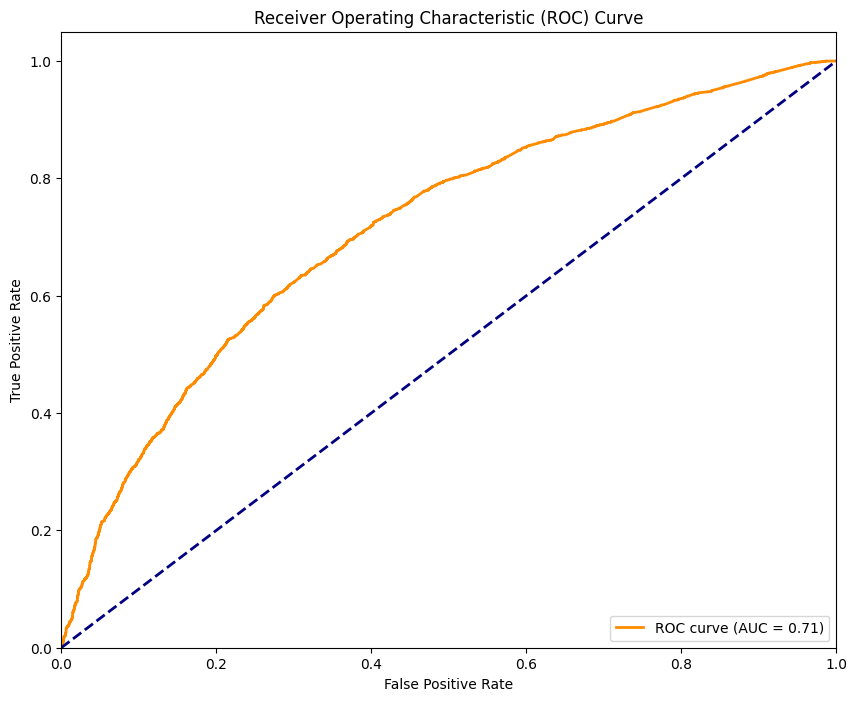

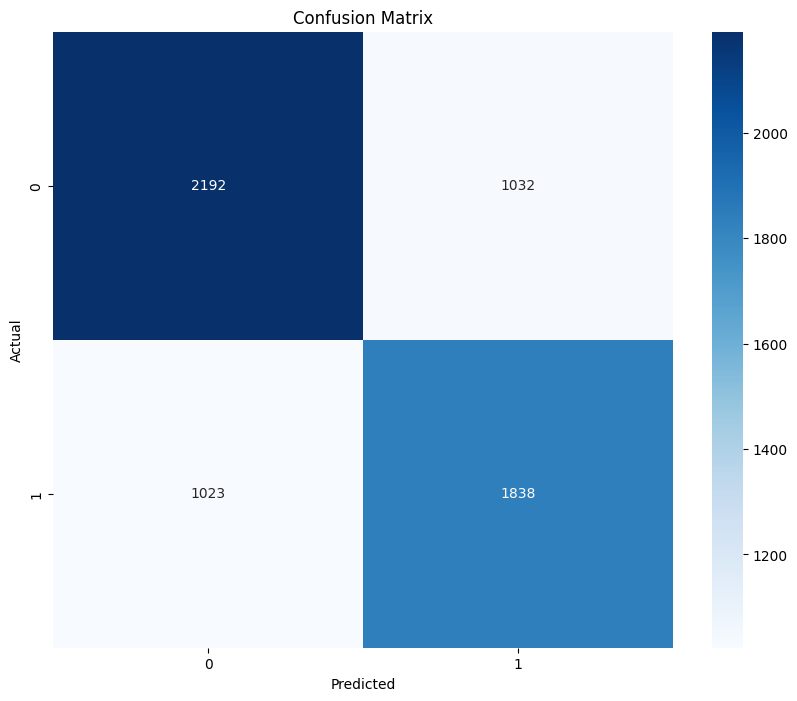

Accuracy: 0.6623
Precision: 0.6404
Recall: 0.6424
F1 Score: 0.6414


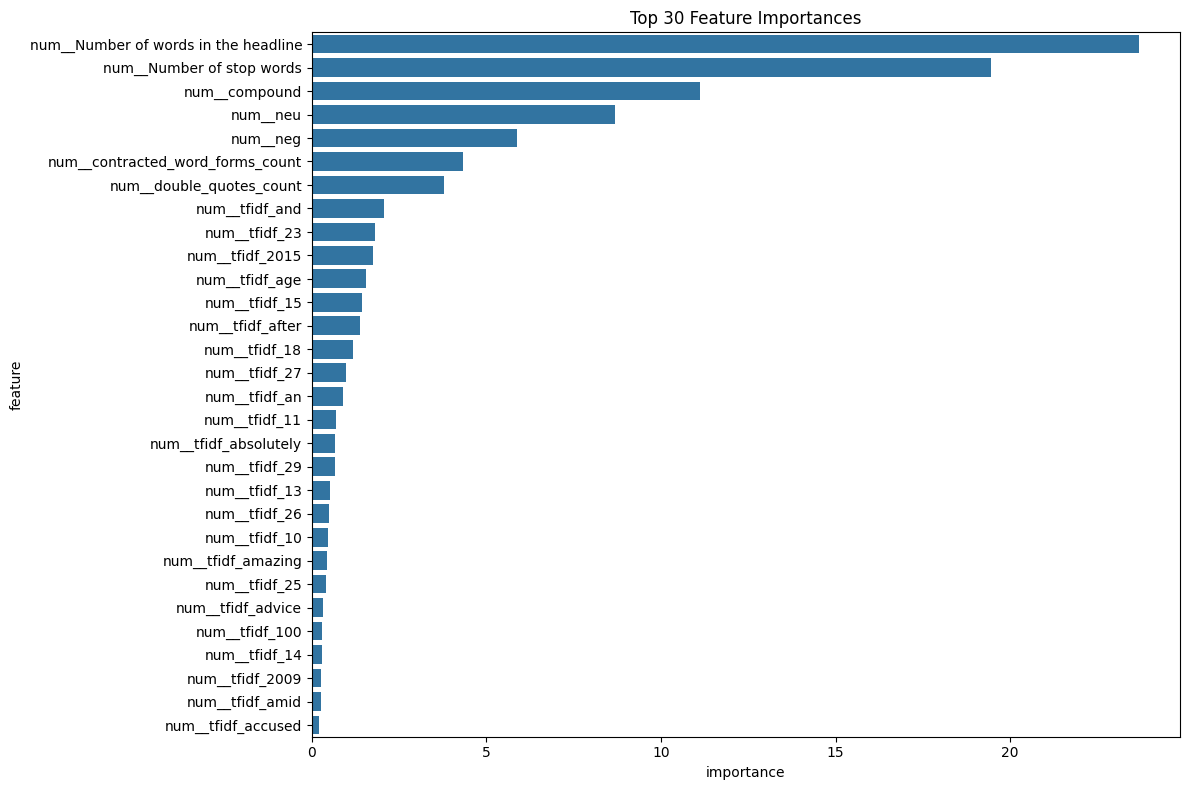

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# calculate and print evaluation metrics
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# feature importance
feature_importance = best_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# create dataframe of feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# sort by importance and select top 30 features
top_30_features = feature_importance_df.sort_values('importance', ascending=False).head(30)

# plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_30_features)
plt.title('Top 30 Feature Importances')
plt.tight_layout()
plt.show()

Shape of shap_values: (6085, 612)
Shape of X_test: (6085, 612)
Number of feature_names: 612


<Figure size 1000x600 with 0 Axes>

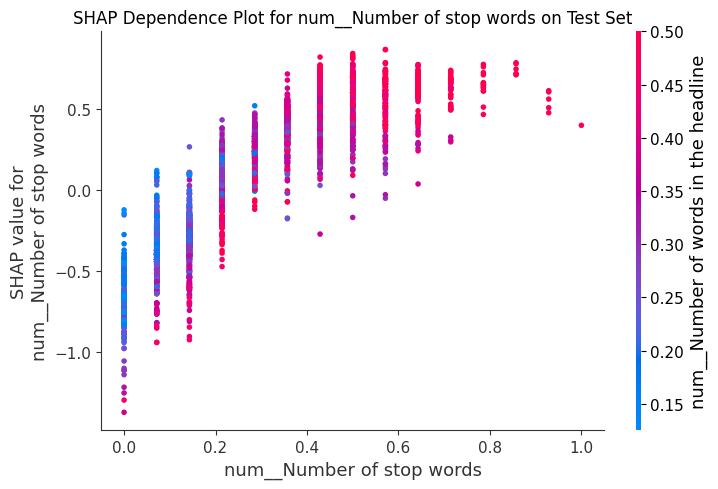

<Figure size 1000x600 with 0 Axes>

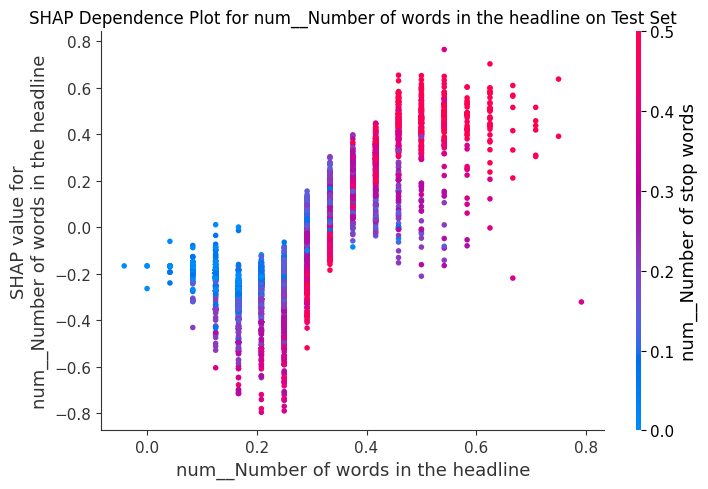

<Figure size 1000x600 with 0 Axes>

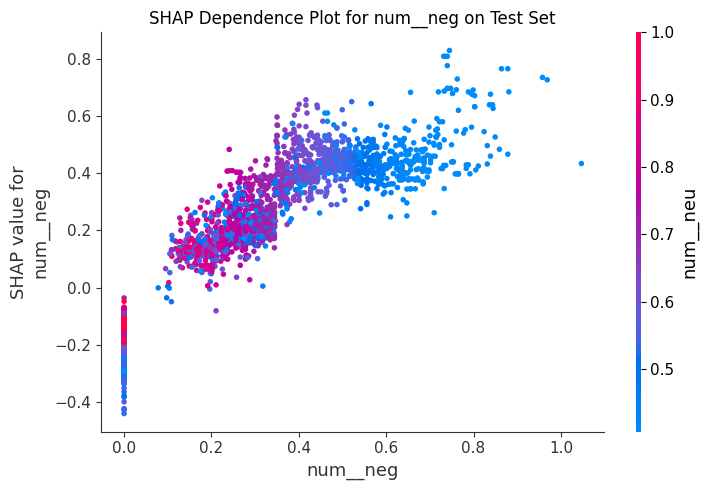

<Figure size 1000x600 with 0 Axes>

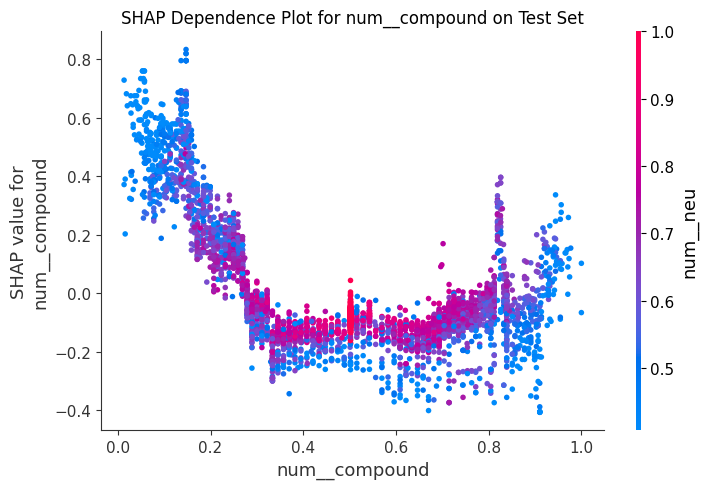

<Figure size 1000x600 with 0 Axes>

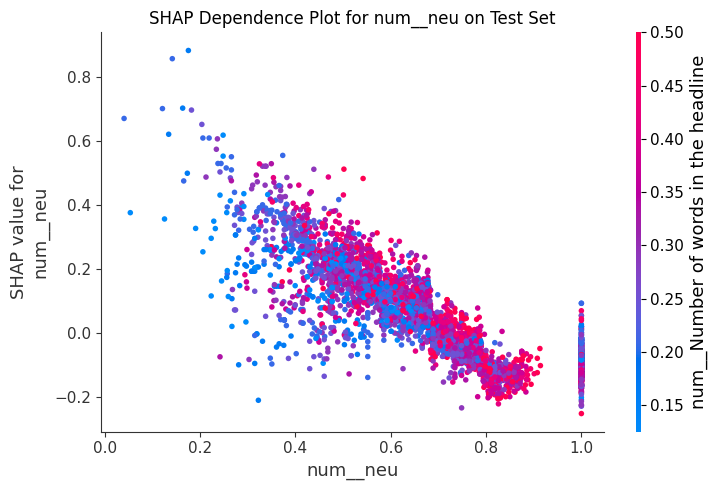

<Figure size 1000x600 with 0 Axes>

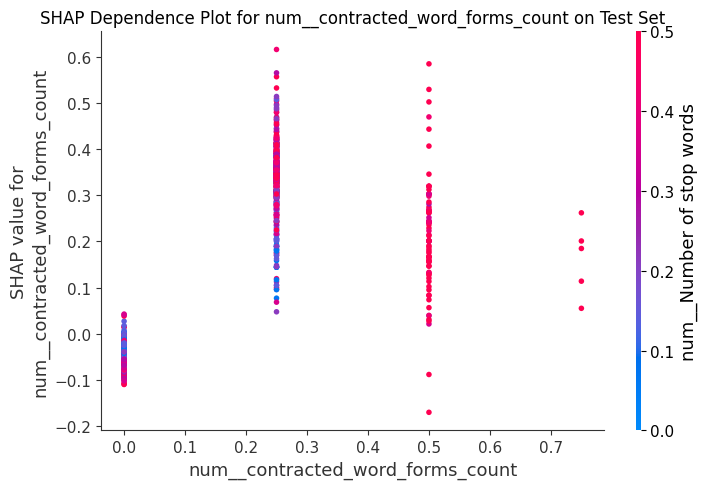

<Figure size 1000x600 with 0 Axes>

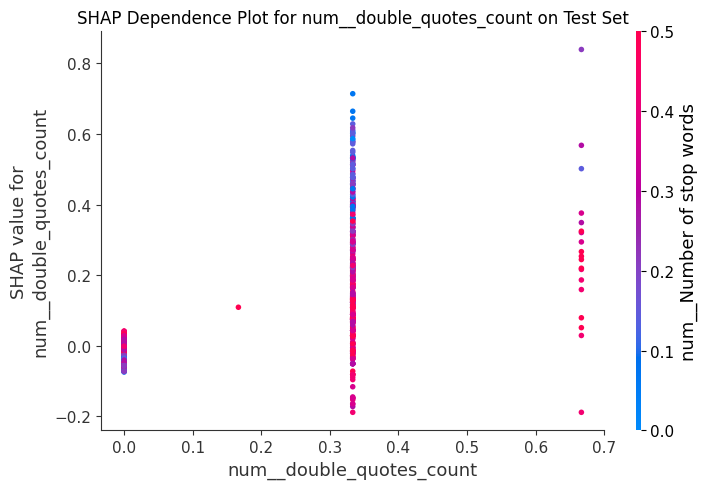

<Figure size 1000x600 with 0 Axes>

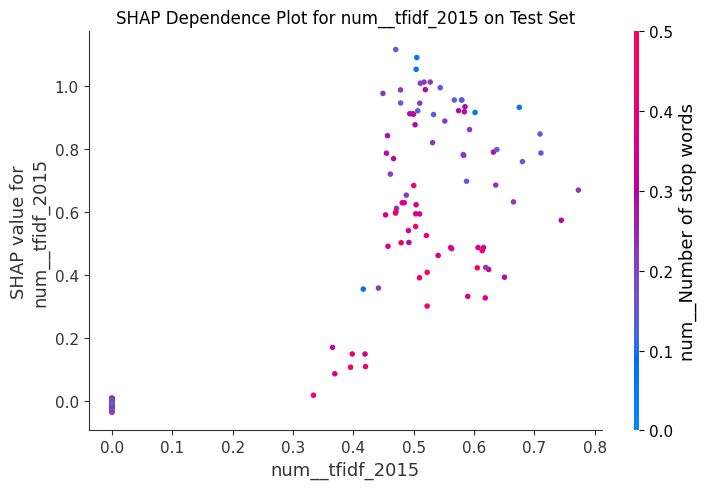

<Figure size 1000x600 with 0 Axes>

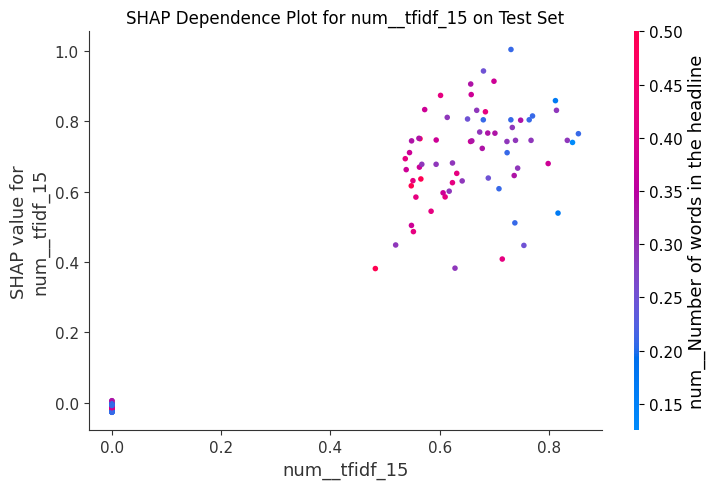

<Figure size 1000x600 with 0 Axes>

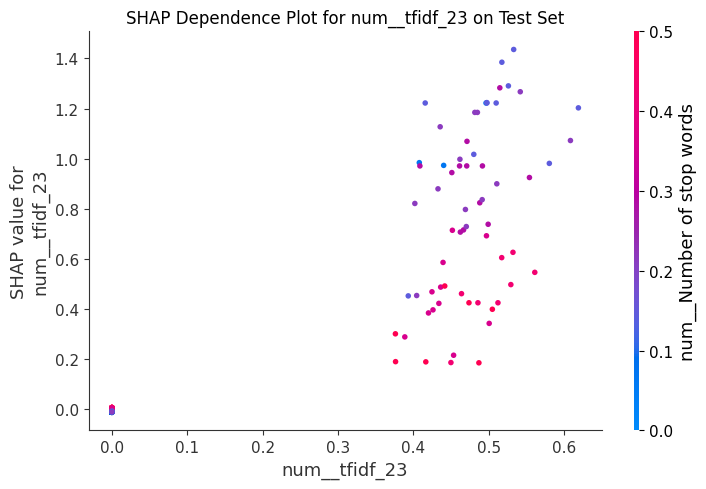

<Figure size 1000x600 with 0 Axes>

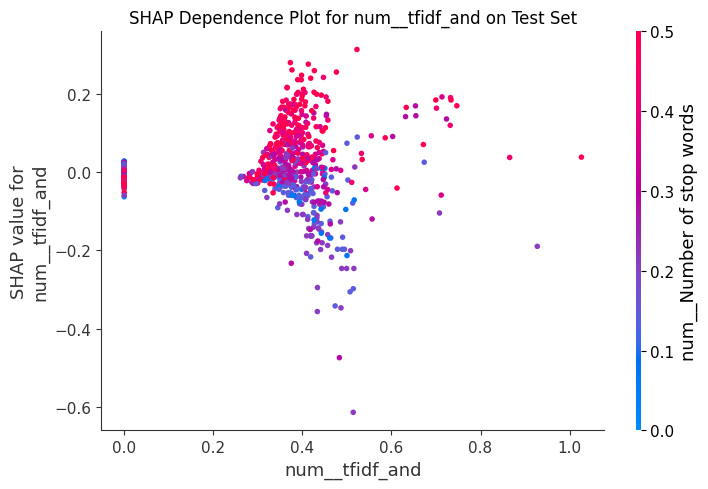

<Figure size 1000x600 with 0 Axes>

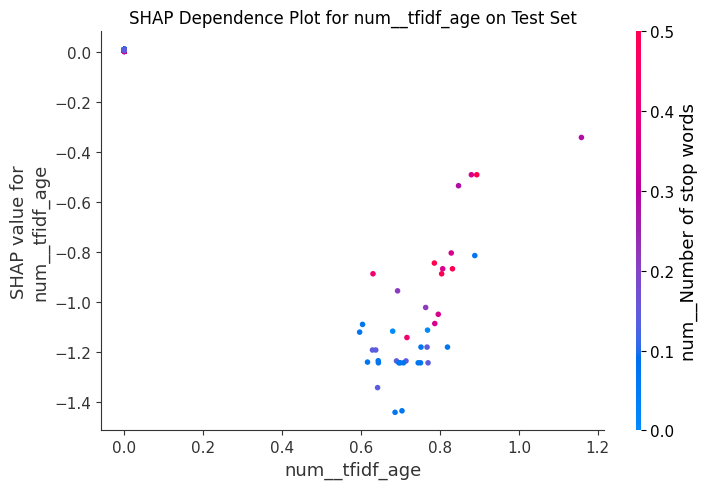

<Figure size 1000x600 with 0 Axes>

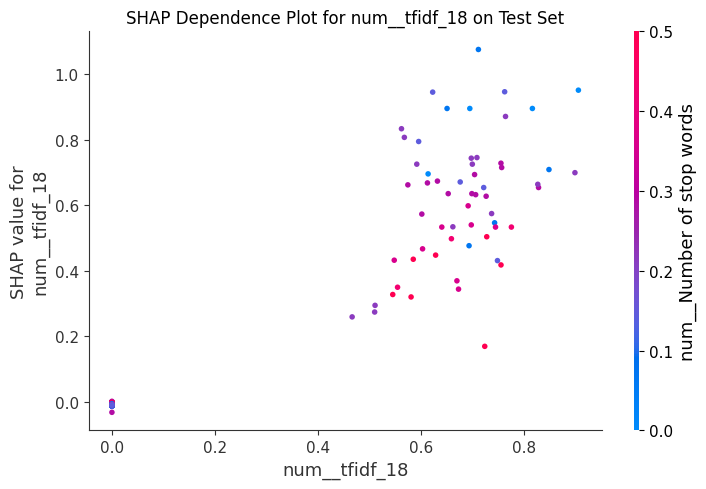

<Figure size 1000x600 with 0 Axes>

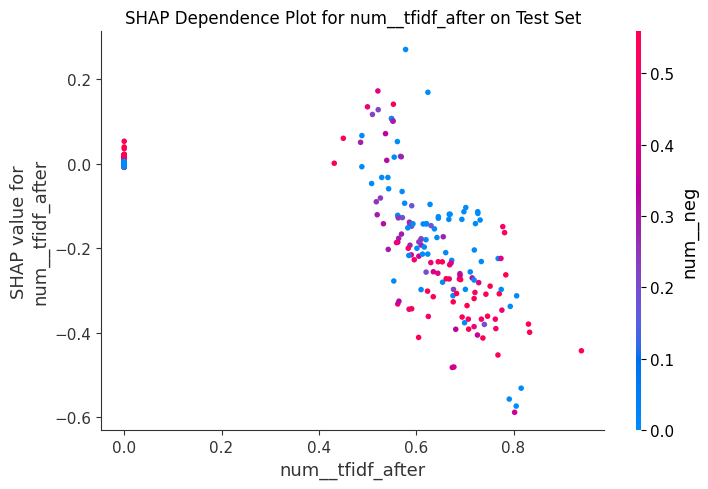

<Figure size 1000x600 with 0 Axes>

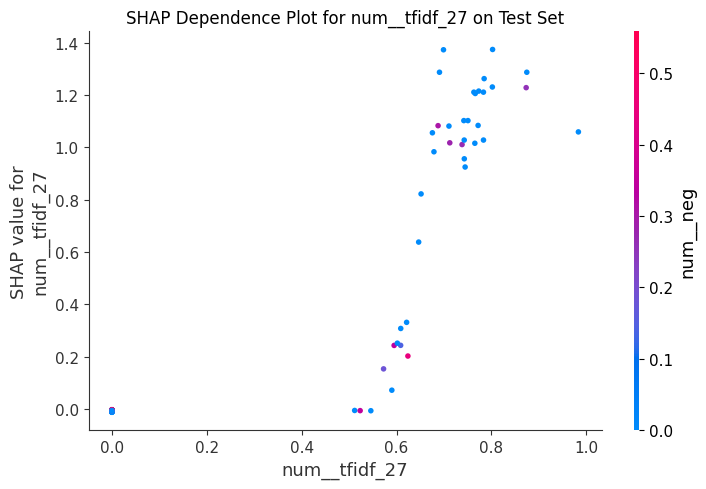

<Figure size 1000x600 with 0 Axes>

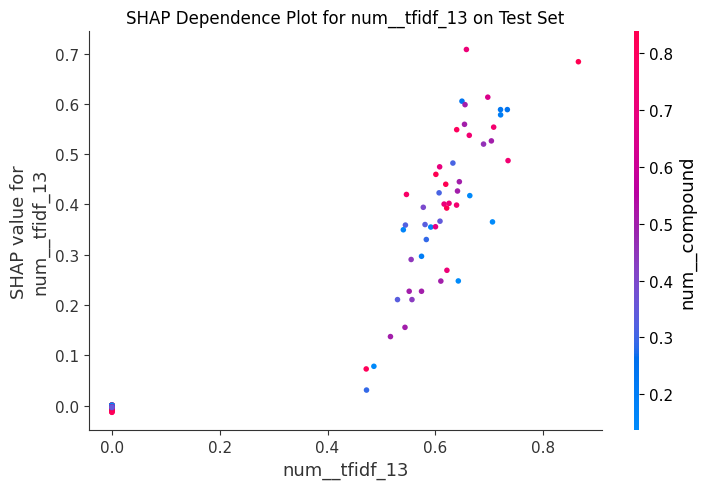

<Figure size 1000x600 with 0 Axes>

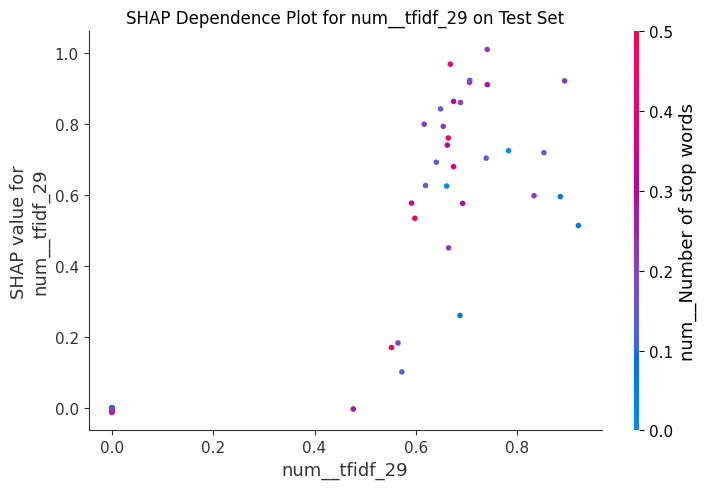

<Figure size 1000x600 with 0 Axes>

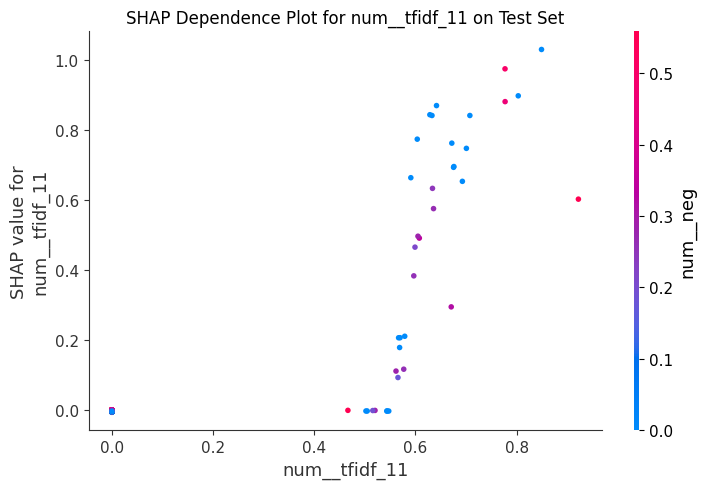

<Figure size 1000x600 with 0 Axes>

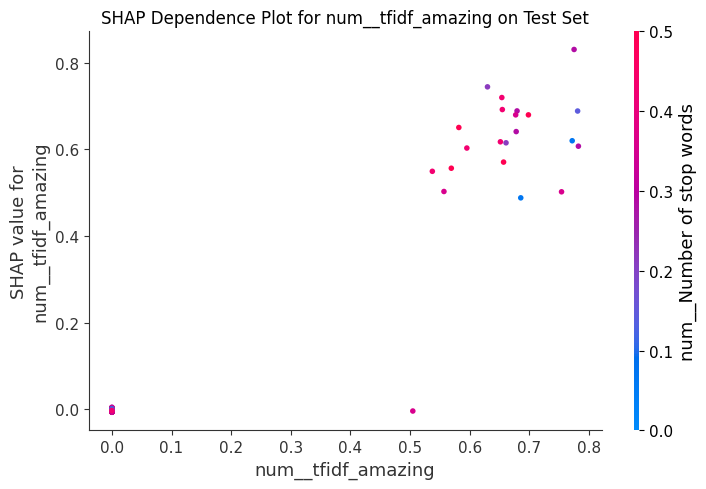

<Figure size 1000x600 with 0 Axes>

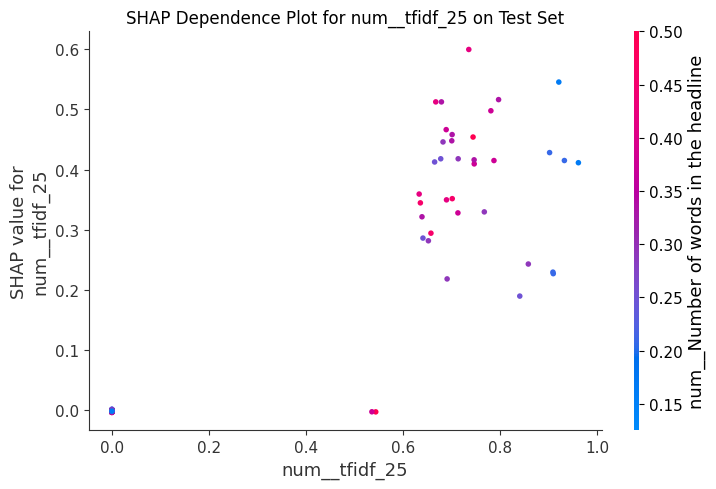

<Figure size 1000x600 with 0 Axes>

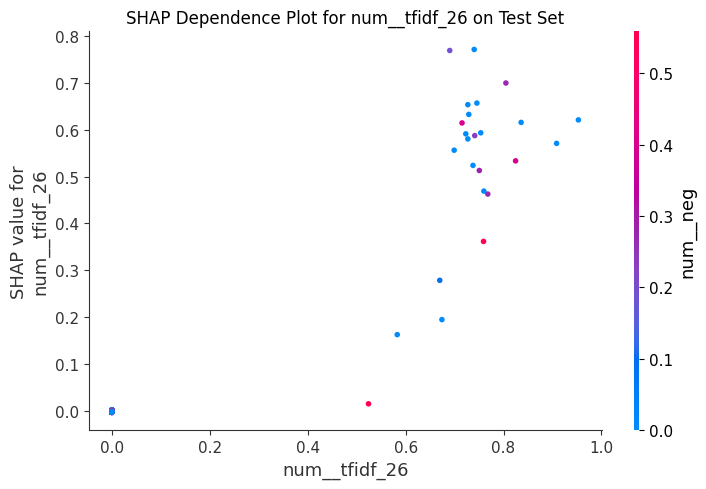

<Figure size 1000x600 with 0 Axes>

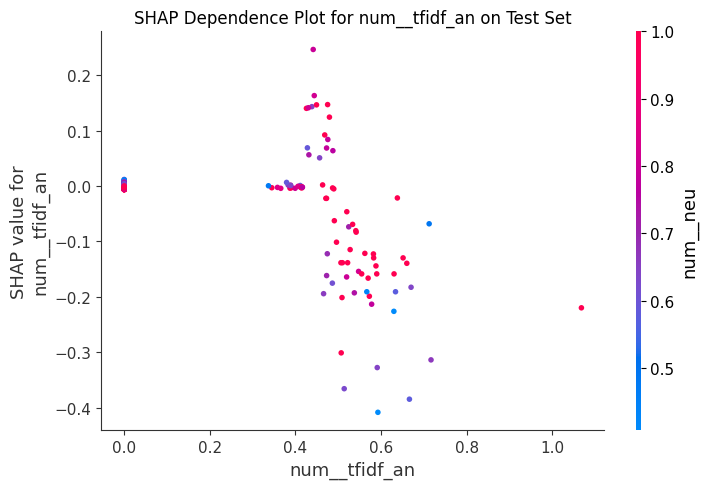

<Figure size 1000x600 with 0 Axes>

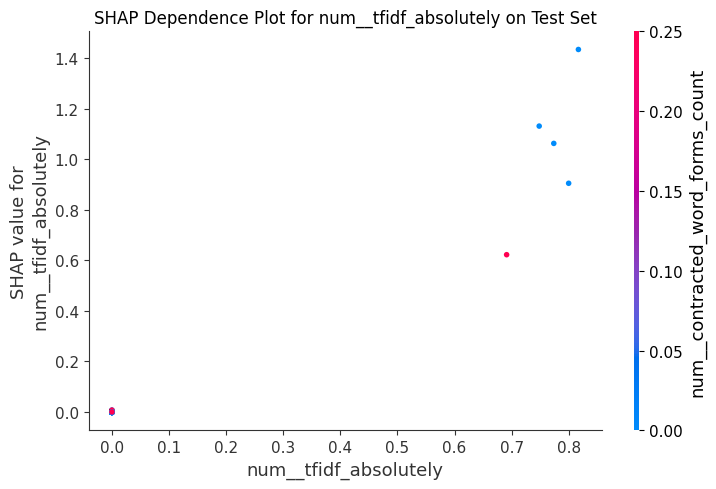

<Figure size 1000x600 with 0 Axes>

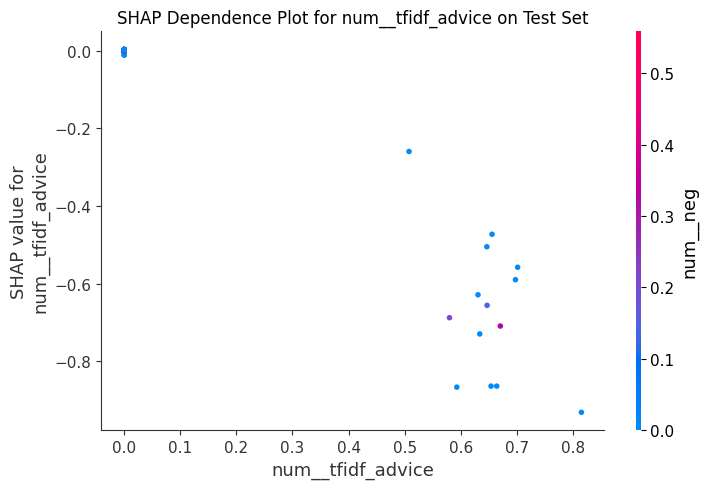

<Figure size 1000x600 with 0 Axes>

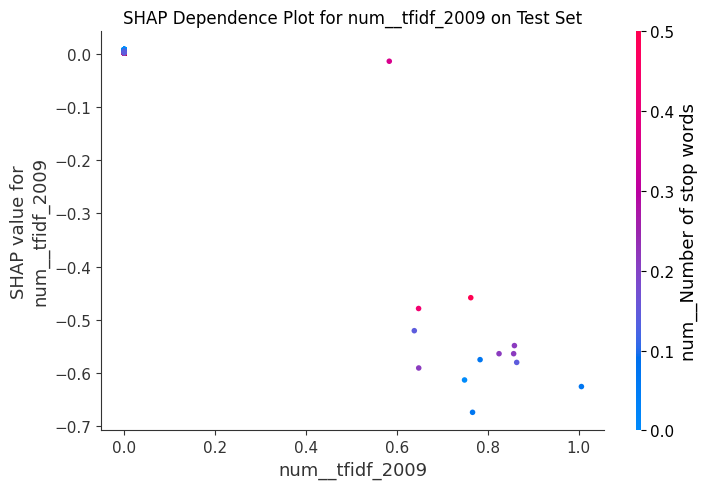

<Figure size 1000x600 with 0 Axes>

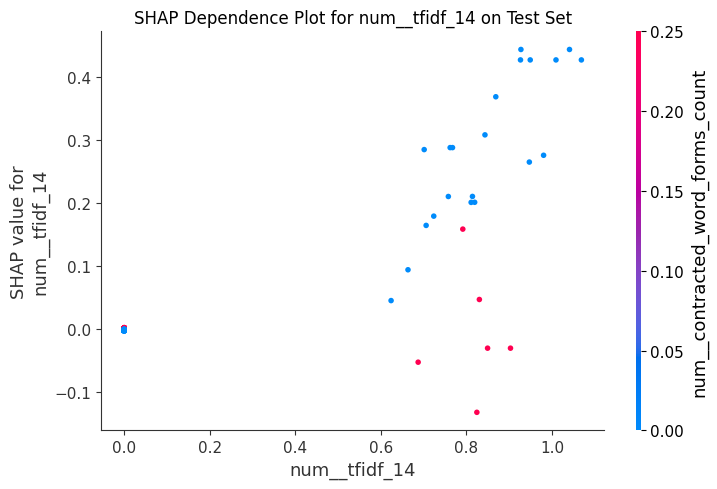

<Figure size 1000x600 with 0 Axes>

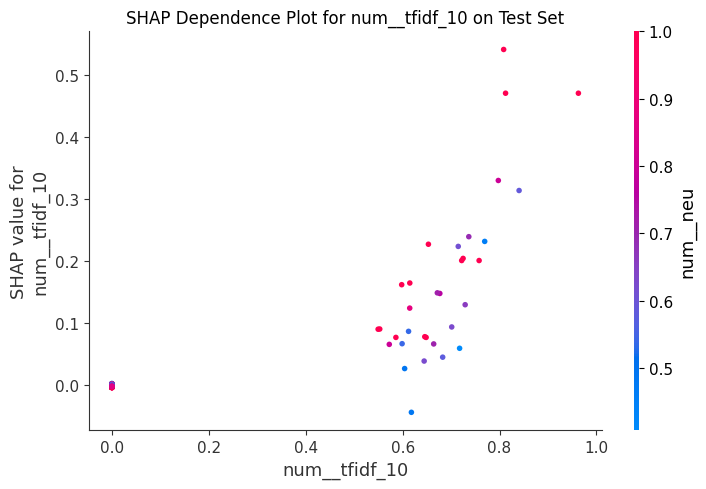

<Figure size 1000x600 with 0 Axes>

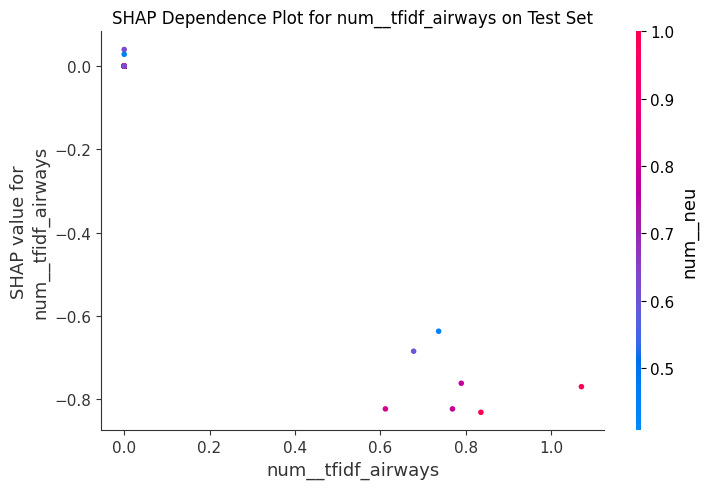

<Figure size 1000x600 with 0 Axes>

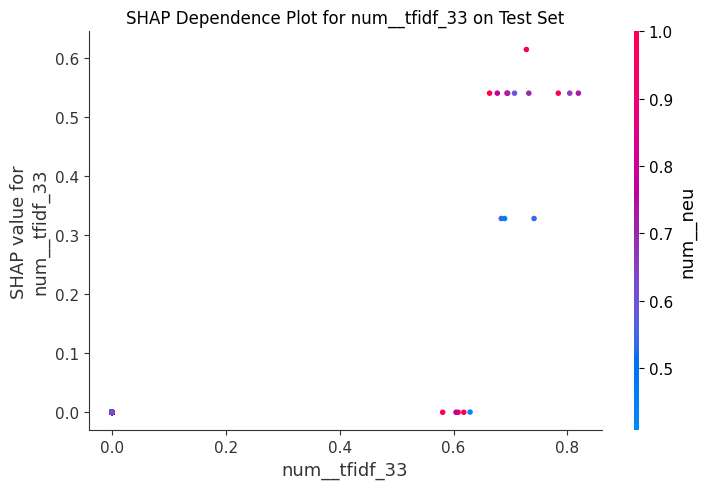

<Figure size 1000x600 with 0 Axes>

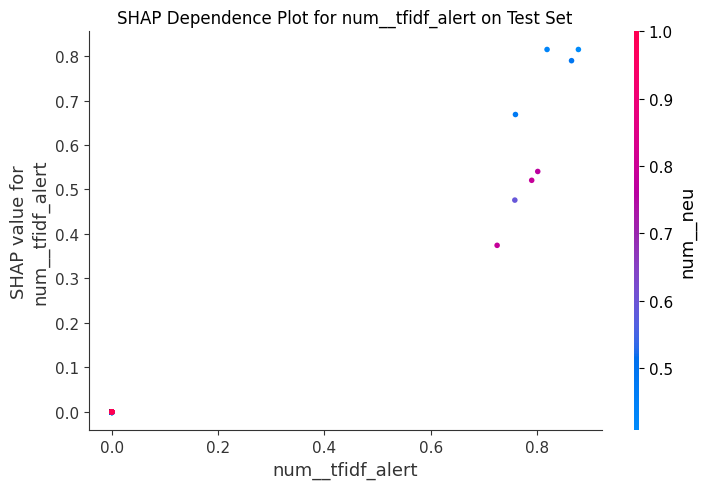

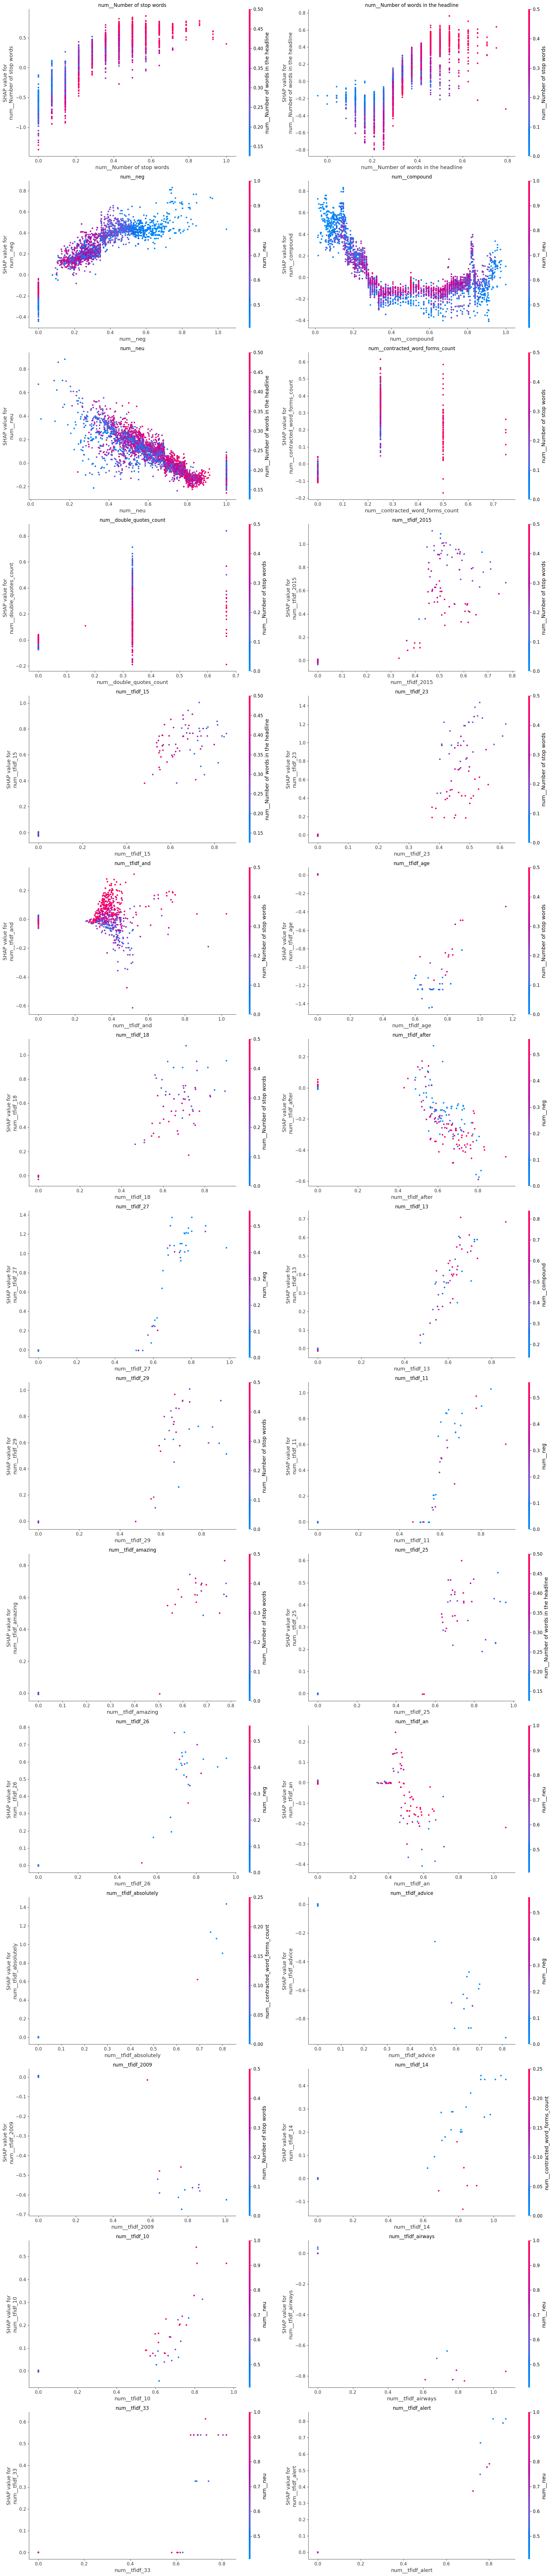

Top 30 features and their importance scores:
num__Number of stop words: 0.34325859921251495
num__Number of words in the headline: 0.22455148756126306
num__neg: 0.2156884874689986
num__compound: 0.1421592429372385
num__neu: 0.10990387915869441
num__contracted_word_forms_count: 0.08252971502799733
num__double_quotes_count: 0.03919199515642188
num__tfidf_2015: 0.018114135557603876
num__tfidf_15: 0.016650582534127448
num__tfidf_23: 0.01659078712457105
num__tfidf_and: 0.01322458353845711
num__tfidf_age: 0.013219160828140473
num__tfidf_18: 0.012714078852971763
num__tfidf_after: 0.011492126974732801
num__tfidf_27: 0.011472402301417045
num__tfidf_13: 0.006719921247992481
num__tfidf_29: 0.0066917241355606534
num__tfidf_11: 0.006459988053539539
num__tfidf_amazing: 0.004529557346753544
num__tfidf_25: 0.004447369124827932
num__tfidf_26: 0.004331506277605942
num__tfidf_an: 0.0031035614403299864
num__tfidf_absolutely: 0.0029962756851679047
num__tfidf_advice: 0.0027314721226969286
num__tfidf_2009: 0.

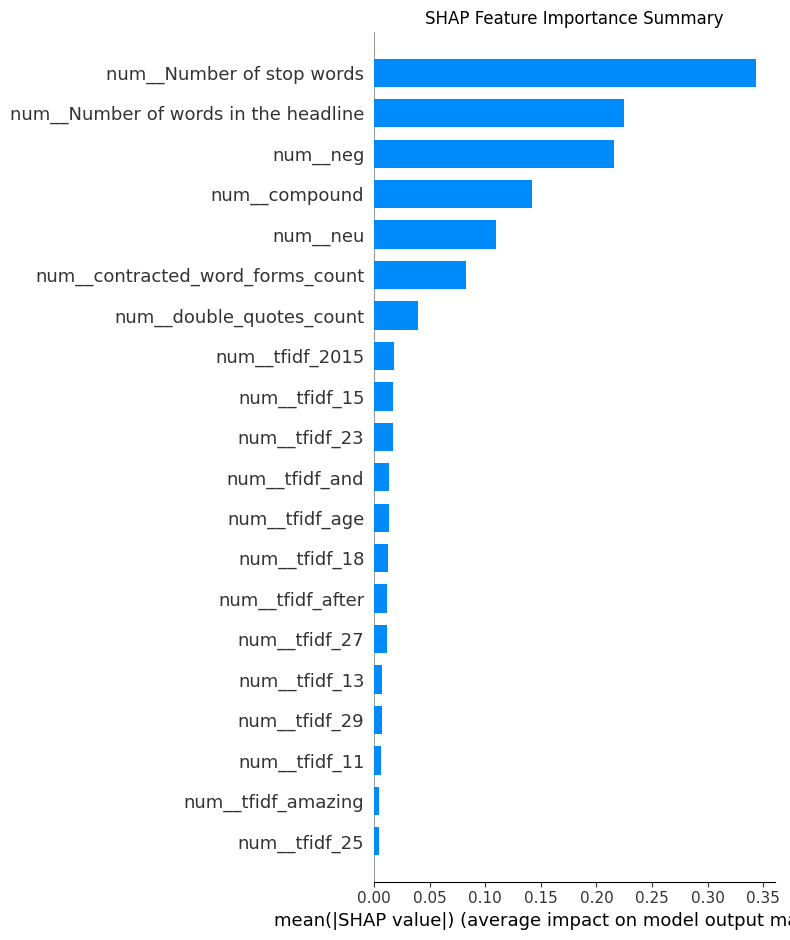

In [ ]:
# SHAP analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# select the SHAP value of the positive class
shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values

# make sure feature_names is a one-dimensional array
feature_names = preprocessor.get_feature_names_out()
feature_names = [name[0] if isinstance(name, np.ndarray) else name for name in feature_names]

# get feature importance
feature_importance = np.abs(shap_values).mean(0)
feature_importance_sorted = np.argsort(-feature_importance)

# select the top N important features
N = 30  # adjustable
top_features = feature_importance_sorted[:N]

# print diagnostic information
print("Shape of shap_values:", shap_values.shape)
print("Shape of X_test:", X_test.shape)
print("Number of feature_names:", len(feature_names))

# draw a dependency graph for each top-level feature
for i, feature_idx in enumerate(top_features):
    try:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            int(feature_idx),
            shap_values,
            X_test,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {feature_names[feature_idx]} on Test Set")
        plt.tight_layout()
        plt.savefig(f'{base_dir}/shap_dependence_{feature_names[feature_idx]}_test.png',
                    dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error plotting feature {feature_names[feature_idx]}: {str(e)}")

# plot a combination of all top features
try:
    fig, axes = plt.subplots(nrows=(N+1)//2, ncols=2, figsize=(20, 6*((N+1)//2)))
    axes = axes.flatten()

    for i, feature_idx in enumerate(top_features):
        shap.dependence_plot(
            int(feature_idx),
            shap_values,
            X_test,
            feature_names=feature_names,
            ax=axes[i],
            show=False
        )
        axes[i].set_title(f"{feature_names[feature_idx]}")

    if N % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.savefig(f'{base_dir}/shap_dependence_top_{N}_features_test.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"Error plotting combined figure: {str(e)}")

# print the top N important features and their importance scores
print("Top", N, "features and their importance scores:")
for idx in top_features:
    print(f"{feature_names[idx]}: {feature_importance[idx]}")

# overall feature importance map
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance Summary")
plt.tight_layout()
plt.savefig(f'{base_dir}/shap_feature_importance_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
!pip install pipdeptree
!pipdeptree

Streaming output truncated to the last 5000 lines.
│   │   ├── idna [required: >=2.5,<4, installed: 3.7]
│   │   └── urllib3 [required: >=1.21.1,<3, installed: 2.0.7]
│   └── xyzservices [required: Any, installed: 2024.6.0]
├── ipython [required: Any, installed: 7.34.0]
│   ├── backcall [required: Any, installed: 0.2.0]
│   ├── decorator [required: Any, installed: 4.4.2]
│   ├── jedi [required: >=0.16, installed: ?]
│   ├── matplotlib-inline [required: Any, installed: 0.1.7]
│   │   └── traitlets [required: Any, installed: 5.7.1]
│   ├── pexpect [required: >4.3, installed: 4.9.0]
│   │   └── ptyprocess [required: >=0.5, installed: 0.7.0]
│   ├── pickleshare [required: Any, installed: 0.7.5]
│   ├── prompt_toolkit [required: >=2.0.0,<3.1.0,!=3.0.1,!=3.0.0, installed: 3.0.47]
│   │   └── wcwidth [required: Any, installed: 0.2.13]
│   ├── Pygments [required: Any, installed: 2.16.1]
│   ├── setuptools [required: >=18.5, installed: 71.0.4]
│   └── traitlets [required: >=4.2, installed: 5.7.

In [ ]:
import sys

for name, module in sys.modules.items():
    if hasattr(module, '__file__') and module.__file__:
        print(name)

_frozen_importlib
_frozen_importlib_external
codecs
encodings.aliases
encodings
encodings.utf_8
abc
io
types
enum
sre_constants
sre_parse
sre_compile
_collections_abc
keyword
operator
reprlib
collections
functools
copyreg
re
warnings
stat
genericpath
posixpath
os.path
os
_sitebuiltins
_distutils_hack
importlib._bootstrap
importlib._bootstrap_external
importlib
importlib._abc
contextlib
importlib.util
importlib.machinery
google
sitecustomize
site
runpy
ipykernel._version
_json
json.scanner
json.decoder
json.encoder
json
signal
_weakrefset
threading
collections.abc
selectors
subprocess
IPython.core
IPython.core.getipython
IPython.core.release
weakref
copy
fnmatch
glob
token
tokenize
linecache
traceback
string
logging
_compression
_bz2
bz2
_lzma
lzma
shutil
ast
_opcode
opcode
dis
inspect
typing
traitlets.utils
traitlets.utils.bunch
traitlets.utils.descriptions
traitlets.utils.getargspec
traitlets.utils.importstring
traitlets.utils.sentinel
traitlets.traitlets
traitlets._version
traitlets.

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.13
albumentations                   1.4.14
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.8.19.0.32.16
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread              

In [ ]:
!pip freeze
!pip freeze > requirements.txt

absl-py==1.4.0
accelerate==0.32.1
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.13
albumentations==1.4.14
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.2
astropy-iers-data==0.2024.8.19.0.32.16
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.6.2
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.15.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
catboost==1.2.5
certifi==2024.7.4
cffi==1.17.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.18.1
cloudpickle==2.2.1
cmake==3.30.2
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
communit